# <font color='red'>  Clasificación de Satélites por Grupo </font>

<font color='grey'>Grupo: Miguel Carralero Lanchares y Luis Palomo de Onís Hernández </font>

## 0. Introducción

### - Base de Datos

Se decide trabajar con los **catálogos de satélites** encontrados en el repositorio público de **Space-Track** (EEUU). El dato fundamental con el que se va a trabajar es el **TLE (Two Line Element)**, un conjunto de 13 números que dan información precisa sobre las características descriptivas de la órbita de un objeto y su posición en la misma, en un instante temporal determinado. La página web de Space-Track publica los TLEs de todos los objetos no clasificados diariamente, teniendo algunos actualización del día y otros no (de algunos objetos, por su lejanía, se obtienen menos mediciones de su posición desde los sensores terrestres y por tanto no se puede actualizar su posición diariamente).

### - Preprocesado

Primero notamos que algunas columnas son siempre constantes y por lo tanto no aportarán valor a nuestro modelo. Este es el caso, por ejemplo, del año de las observaciones (en nuestro caso será siempre 25), o del modelo matemático de **propagación orbital** que se ha usado para determinar las órbitas (en el caso del escuadrón que produce este catálogo, siempre usa el modelo que corresponde al código 0, especificado en la séptima columna de la primera línea). 

Además, se descarta también el dato **“Checksum”**, pues solo sirve para comprobar que el TLE está bien formado y que no ha habido errores en su envío. Parseamos toda esta información para tener cada archivo diario organizado tabularmente en un .csv.

### - Etiquetado

La línea de trabajo consiste en crear un **clasificador** que sea capaz de identificar a un objeto a partir de los datos orbitales. En este caso, el imput del modelo serían todas las columnas de la parte derecha de la tabla y el output sería el identificador (**NORAD_ID**). Se contempla que la complejidad de dicho clasificador radica en las múltiples clases con las que tendría que trabajar (hay unos 60.000 objetos distintos), y por ello se reduce el problema a subgrupos que comparten condiciones, funcionalidades y naturalezas similares. Estos subgrupos se obtienen de otra fuente de información de gran relevancia en el ámbito de la vigilancia espacial: **Celestrak.org**.

En cada uno de estos archivos aparece una lista de elementos (solo con su NORAD_ID y su nombre) que pertenecen al subgrupo. Se ha escrito un pequeño código de Python que permita fusionar los dos tipos de datos, de modo que tengamos el listado completo de los TLEs junto con el nombre del objeto y el subgrupo al que pertenece (unión de tablas por la clave NORAD_ID). Nos quedarían los datos etiquetados de esta forma (dos columnas de la derecha: nombre y grupo).

### - Limpieza

Por último, se ha identificado que existen varios grupos que dificultan el tratamiento de los datos. Por un lado están los que pertenecen al grupo **“active”**, correspondientes a los satélites que se sabe que están activos. Se decide eliminar este grupo ya que se superpone a los demás y hace que la mayoría de datos tengan dobles etiquetas. De esta forma nos quedamos con los grupos que realmente clasifican la naturaleza del satélite.  

Adicionalmente, se decide eliminar los **desconocidos** (etiquetados como “Unknown”) ya que no aportan nada a la clasificación y la clase se comporta como una especie de **“cajón desastre”**. También se plantea como posible trabajo futuro aplicar los modelos a dichas clases para poder tener una intuición de las características de estos objetos. 

Finalmente, se identifica que el problema está **altamente desbalanceado por la gran cantidad de satélites Starlink existentes**. Se decide entonces desbalancear el problema descartando una cantidad considerable de dichos. Empecemos ahora con el código:

- **Nota:** Este proyecto incluye modelos individuales previamente entrenados y almacenados en la carpeta del proyecto. Si se desea reentrenar alguno de ellos, simplemente elimine el archivo correspondiente del directorio; el sistema detectará su ausencia y procederá a generar un nuevo modelo entrenado desde cero.

## <font color='gray'> Librerias</font>

<font color='gray'> Esta sección se dedica a la **configuración del entorno de trabajo**, gestionando las **librerías y paquetes** fundamentales para la ejecución del proyecto, desde su instalación hasta su importación.</font>

#### <font color='gray'>- Instalacion:</font>

In [6]:
%pip install matplotlib numpy pandas scikit-learn seaborn xgboost

Note: you may need to restart the kernel to use updated packages.


#### <font color='gray'>- Importación:</font>

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score, 
                           roc_curve, auc)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, ClassifierMixin

from xgboost import XGBClassifier
from joblib import dump, load


# Configuración
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("husl")


## 1. Carga y Preprocesamiento de Datos

En esta sección, se **cargan** los conjuntos de datos de entrenamiento y validación desde múltiples archivos CSV.

Se realiza un **preprocesamiento inicial**, incluyendo la normalización de la columna 'Group' y la **eliminación de registros** con etiquetas 'active' y 'unknown', además de un **submuestreo** de la clase 'starlink' para balancear los datos.

In [8]:
# Función para cargar múltiples archivos CSV
def load_multiple_csv(file_paths):
    dfs = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"Error cargando {file_path}: {e}")
    if not dfs: # Manejar el caso donde no se cargaron archivos
        return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

# Cargar datos de entrenamiento y validación
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "DDBB"))

train_files = [
    os.path.join(BASE_PATH, "001_TLE_22ABR_J111_labelled.csv"),
    os.path.join(BASE_PATH, "002_TLE_23ABR_J112_labelled.csv"),
    os.path.join(BASE_PATH, "003_TLE_24ABR_J113_labelled.csv"),
    os.path.join(BASE_PATH, "004_TLE_25ABR_J114_labelled.csv"),
    os.path.join(BASE_PATH, "005_TLE_26ABR_J115_labelled.csv"),
    os.path.join(BASE_PATH, "006_TLE_27ABR_J116_labelled.csv"),
    os.path.join(BASE_PATH, "007_TLE_28ABR_J117_labelled.csv"),
    os.path.join(BASE_PATH, "008_TLE_29ABR_J118_labelled.csv"),
    os.path.join(BASE_PATH, "009_TLE_30ABR_J119_labelled.csv"),
    os.path.join(BASE_PATH, "010_TLE_01MAY_J120_labelled.csv"),
    os.path.join(BASE_PATH, "011_TLE_02MAY_J121_labelled.csv"),
    os.path.join(BASE_PATH, "012_TLE_03MAY_J122_labelled.csv"),
]

val_files = [
    os.path.join(BASE_PATH, "013_TLE_04MAY_J123_labelled.csv"),
    os.path.join(BASE_PATH, "014_TLE_05MAY_J124_labelled.csv"),
    os.path.join(BASE_PATH, "015_TLE_06MAY_J125_labelled.csv"),
]

df_train = load_multiple_csv(train_files)
df_val = load_multiple_csv(val_files)

# Primero, asegurarse de que la columna 'Group' es de tipo string y normalizarla
if 'Group' in df_train.columns: # Verificar si la columna existe
    df_train['Group'] = df_train['Group'].astype(str).str.lower().str.strip()
if 'Group' in df_val.columns: # Verificar si la columna existe
    df_val['Group'] = df_val['Group'].astype(str).str.lower().str.strip()

# Ahora filtramos y eliminamos los registros con etiqueta "Unknown" y "Active"
df_train = df_train[~df_train['Group'].isin(['active', 'unknown'])]
df_val = df_val[~df_val['Group'].isin(['active', 'unknown'])]


# Seleccionamos aleatoriamente el 60% de los registros del grupo "Starlink"
starlink_names = df_train[df_train['Group'] == 'starlink']['Name'].unique()
names_to_remove = pd.Series(starlink_names).sample(frac=0.6, random_state=42)

# Eliminamos estos registros para balancear los datos 
df_train = df_train[~((df_train['Group'] == 'starlink') & (df_train['Name'].isin(names_to_remove)))]
df_val = df_val[~((df_val['Group'] == 'starlink') & (df_val['Name'].isin(names_to_remove)))]


# Mostrar estructura de los datos
print("Columnas disponibles:")
print(df_train.columns.tolist())
print("\nPrimeras filas del entrenamiento (después de filtrar 'active'):")
display(df_train.head())

# Para verificar, puedes imprimir los valores únicos de la columna 'Group' después de filtrar
print("\nValores únicos en 'Group' después de filtrar (entrenamiento):")
print(df_train['Group'].unique())
print("\nValores únicos en 'Group' después de filtrar (validación):")
print(df_val['Group'].unique())

Columnas disponibles:
['NORAD_ID', 'Int_Designator', 'Epoch_Day', 'First_Derivative', 'Second_Derivative', 'BSTAR', 'Inclination', 'RAAN', 'Eccentricity', 'Argument_of_Perigee', 'Mean_Anomaly', 'Mean_Motion', 'Revolution_Number', 'Name', 'Group']

Primeras filas del entrenamiento (después de filtrar 'active'):


,NORAD_ID,Int_Designator,Epoch_Day,First_Derivative,Second_Derivative,BSTAR,Inclination,RAAN,Eccentricity,Argument_of_Perigee,Mean_Anomaly,Mean_Motion,Revolution_Number,Name,Group
304,694,63047A,110.494363,0.000029,0.0,34.746,30.3513,199.5108,0.055441,115.6262,250.2666,14.104222,8593,ATLAS CENTAUR 2,visual
305,694,63047A,111.555936,0.000032,0.0,38.633,30.3516,193.5943,0.055429,124.9381,240.4569,14.104294,8608,ATLAS CENTAUR 2,visual
338,733,64002A,110.932489,0.000004,0.0,17.422,99.1126,101.8824,0.003399,117.1669,243.2985,14.337802,19204,THOR AGENA D R/B,visual
339,733,64002A,111.490770,0.000005,0.0,20.245,99.1127,102.4703,0.003400,115.5786,244.8917,14.337813,19212,THOR AGENA D R/B,visual
372,862,64047B,110.517936,-0.000002,0.0,0.000,16.1644,91.2127,0.713429,163.5853,244.7562,2.051038,24948,DELTA 1 R/B,gpz plus



Valores únicos en 'Group' después de filtrar (entrenamiento):
['visual' 'gpz plus' 'satnogs' 'nnss' 'noaa' 'molniya' 'raduga' 'goes'
 'gorizont' 'orbcomm' 'cosmos 2251 debris' 'iridium' 'gnss' 'ses'
 'iridium 33 debris' 'globalstar' 'weather' 'musson' 'fengyun 1c debris'
 'intelsat' 'eutelsat' 'education' 'beidou' 'galileo' 'iridium next'
 'swarm' 'oneweb' 'starlink' 'stations' 'cosmos 1408 debris'
 'last 30 days' 'analyst']

Valores únicos en 'Group' después de filtrar (validación):
['visual' 'gpz plus' 'satnogs' 'nnss' 'noaa' 'molniya' 'raduga' 'goes'
 'gorizont' 'orbcomm' 'cosmos 2251 debris' 'iridium' 'gnss' 'ses'
 'iridium 33 debris' 'globalstar' 'weather' 'musson' 'fengyun 1c debris'
 'intelsat' 'eutelsat' 'education' 'beidou' 'galileo' 'iridium next'
 'swarm' 'oneweb' 'starlink' 'stations' 'cosmos 1408 debris'
 'last 30 days' 'analyst']


## 2. Limpieza y Preparación de Datos

Aquí, se **limpian las columnas numéricas** convirtiéndolas al formato adecuado (europeo a estándar). Se manejan **valores no numéricos** y se asegura que las columnas tengan el tipo de dato `float` para el análisis.

In [9]:
# Función de limpieza para formato europeo
def clean_numeric(value):
    if isinstance(value, str):
        # Reemplazamos comas por puntos y eliminar puntos como separadores de miles
        value = value.replace('.', '') 
        value = value.replace(',', '.') 
    try:
        return float(value)
    except ValueError: 
        return np.nan 

# Columnas numéricas a procesar
numeric_cols = ['Epoch_Day', 'First_Derivative', 'Second_Derivative', 'BSTAR',
               'Inclination', 'RAAN', 'Eccentricity',
               'Argument_of_Perigee', 'Mean_Anomaly', 'Mean_Motion', 'Revolution_Number']

# Aplicamos la limpieza
for df in [df_train, df_val]:
    if not df.empty: # Solo procesar si el DataFrame no está vacío
        for col in numeric_cols:
            if col in df.columns:
                df[col] = df[col].apply(clean_numeric)
            else:
                print(f"Advertencia: La columna '{col}' no se encontró en uno de los DataFrames.")

# Mostramos los resultados
if not df_train.empty:
    print("\nDatos de entrenamiento después de la limpieza:")
    display(df_train.head())
    print("\nTipos de datos:")
    display(df_train.dtypes)
else:
    print("\nEl DataFrame de entrenamiento está vacío después del preprocesamiento.")


Datos de entrenamiento después de la limpieza:


,NORAD_ID,Int_Designator,Epoch_Day,First_Derivative,Second_Derivative,BSTAR,Inclination,RAAN,Eccentricity,Argument_of_Perigee,Mean_Anomaly,Mean_Motion,Revolution_Number,Name,Group
304,694,63047A,110.494363,0.000029,0.0,34.746,30.3513,199.5108,0.055441,115.6262,250.2666,14.104222,8593.0,ATLAS CENTAUR 2,visual
305,694,63047A,111.555936,0.000032,0.0,38.633,30.3516,193.5943,0.055429,124.9381,240.4569,14.104294,8608.0,ATLAS CENTAUR 2,visual
338,733,64002A,110.932489,0.000004,0.0,17.422,99.1126,101.8824,0.003399,117.1669,243.2985,14.337802,19204.0,THOR AGENA D R/B,visual
339,733,64002A,111.490770,0.000005,0.0,20.245,99.1127,102.4703,0.003400,115.5786,244.8917,14.337813,19212.0,THOR AGENA D R/B,visual
372,862,64047B,110.517936,-0.000002,0.0,0.000,16.1644,91.2127,0.713429,163.5853,244.7562,2.051038,24948.0,DELTA 1 R/B,gpz plus



Tipos de datos:


NORAD_ID                 int64
Int_Designator          object
Epoch_Day              float64
First_Derivative       float64
Second_Derivative      float64
BSTAR                  float64
Inclination            float64
RAAN                   float64
Eccentricity           float64
Argument_of_Perigee    float64
Mean_Anomaly           float64
Mean_Motion            float64
Revolution_Number      float64
Name                    object
Group                   object
dtype: object

## 3. Análisis Exploratorio de Datos

Se realiza un **análisis visual** de la distribución de las clases de satélites en el conjunto de entrenamiento.
También se calculan y muestran **estadísticas descriptivas** para las características numéricas.

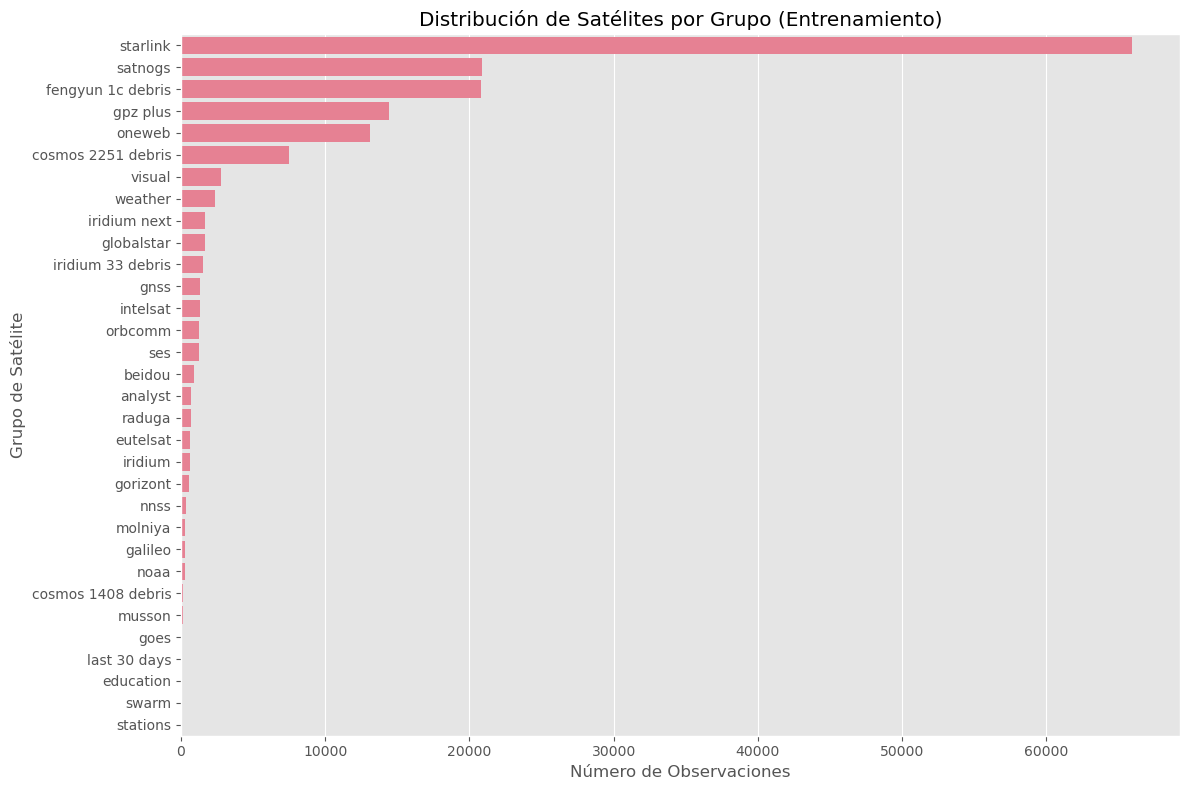


Estadísticas descriptivas:


,Epoch_Day,First_Derivative,Second_Derivative,BSTAR,Inclination,RAAN,Eccentricity,Argument_of_Perigee,Mean_Anomaly,Mean_Motion,Revolution_Number
count,163743.000000,1.637430e+05,163743.000000,163743.000000,163743.000000,163743.000000,163743.000000,163743.000000,163743.000000,163743.000000,163743.000000
mean,116.121427,5.079744e-05,0.945593,27.550644,64.045870,175.586308,0.030272,165.195724,196.081400,12.854604,29725.346757
std,3.622598,2.428382e-03,124.226821,1513.524235,29.172378,102.891555,0.132411,98.016567,100.006186,4.661347,31546.070683
min,92.316995,-2.659523e-02,-3.316700,-85238.000000,0.000300,0.000100,0.000001,0.004800,0.000100,0.086209,2.000000
25%,112.946274,-4.900000e-07,0.000000,0.000000,43.004600,89.669600,0.000142,85.385750,95.791050,13.678007,7685.000000
50%,115.842923,6.770000e-06,0.000000,12.785000,53.218400,172.736800,0.000266,130.998500,233.459300,14.983175,15446.000000
75%,118.372741,4.547000e-05,0.000000,66.152500,97.367600,261.642400,0.002284,264.398700,275.679300,15.182097,40532.500000
max,285.843265,2.168614e-01,29590.000000,76764.000000,153.233700,359.997800,0.943275,359.991600,359.996200,16.465585,99581.000000


In [10]:
if not df_train.empty:
    # Distribución de grupos
    plt.figure(figsize=(12, 8)) # Aumentar un poco el tamaño para mejor legibilidad
    sns.countplot(y='Group', data=df_train, order=df_train['Group'].value_counts().index)
    plt.title('Distribución de Satélites por Grupo (Entrenamiento)')
    plt.xlabel('Número de Observaciones')
    plt.ylabel('Grupo de Satélite') # Añadir etiqueta al eje Y
    plt.tight_layout() # Ajustar para que no se corten las etiquetas
    plt.show()

    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    display(df_train[numeric_cols].describe())
else:
    print("\nNo se puede generar el gráfico de distribución de grupos porque el DataFrame de entrenamiento está vacío.")

## 4. Preparación de Datos para Modelado

Esta sección se enfoca en **seleccionar las características (`features`)** y la variable objetivo (`target`). Se **eliminan valores nulos** y se codifica la variable objetivo usando `LabelEncoder`. Finalmente, las características se **escalan** con `StandardScaler`.

In [11]:
# Definir características y objetivo
features = ['Epoch_Day', 'First_Derivative', 'Second_Derivative', 'BSTAR',
           'Inclination', 'RAAN', 'Eccentricity', 'Argument_of_Perigee',
           'Mean_Anomaly', 'Mean_Motion']
target = 'Group'

# Añadimos 'Name' para usarlo en la predicción de ejemplo después
df_train_model = df_train[features + [target, 'Name']].copy().dropna(subset=features + [target])
df_val_model = df_val[features + [target, 'Name']].copy().dropna(subset=features + [target])

print(f"Tamaño df_train después de limpiar NaNs para modelado: {len(df_train_model)}")
print(f"Tamaño df_val después de limpiar NaNs para modelado: {len(df_val_model)}")

le = LabelEncoder()

# Ajustamos el LabelEncoder con todas las clases posibles de ambos conjuntos limpios
combined_targets = pd.concat([df_train_model[target], df_val_model[target]], ignore_index=True).unique()
le.fit(combined_targets)
y_train_encoded = le.transform(df_train_model[target])
y_val_encoded = le.transform(df_val_model[target])

X_train = df_train_model[features]
X_val = df_val_model[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nDatos preparados para modelado.")
print(f"Forma de X_train_scaled: {X_train_scaled.shape}, Forma de y_train_encoded: {y_train_encoded.shape}")
print(f"Forma de X_val_scaled: {X_val_scaled.shape}, Forma de y_val_encoded: {y_val_encoded.shape}")
print(f"Clases codificadas por LabelEncoder: {list(le.classes_)}")

Tamaño df_train después de limpiar NaNs para modelado: 163743
Tamaño df_val después de limpiar NaNs para modelado: 55006

Datos preparados para modelado.
Forma de X_train_scaled: (163743, 10), Forma de y_train_encoded: (163743,)
Forma de X_val_scaled: (55006, 10), Forma de y_val_encoded: (55006,)
Clases codificadas por LabelEncoder: ['analyst', 'beidou', 'cosmos 1408 debris', 'cosmos 2251 debris', 'education', 'eutelsat', 'fengyun 1c debris', 'galileo', 'globalstar', 'gnss', 'goes', 'gorizont', 'gpz plus', 'intelsat', 'iridium', 'iridium 33 debris', 'iridium next', 'last 30 days', 'molniya', 'musson', 'nnss', 'noaa', 'oneweb', 'orbcomm', 'raduga', 'satnogs', 'ses', 'starlink', 'stations', 'swarm', 'visual', 'weather']


## 5. Entrenamiento de Modelos

Aquí se definen y **entrenan varios modelos de clasificación** (SVM, Random Forest, XGBoost).

Se implementa un sistema para **guardar los modelos entrenados** en archivos `.joblib` y cargarlos si ya existen, ahorrando tiempo en ejecuciones futuras.

In [12]:
# Configuración de modelos actualizada
model_definitions = {
    'SVM': SVC(C=1.0, kernel='rbf', gamma='scale', 
             probability=True, random_state=42, max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5,
                                         class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8,
                            colsample_bytree=0.8, objective='multi:softprob', eval_metric='mlogloss',
                            use_label_encoder=False, random_state=42)
}

trained_models = {}

# Verificación de clases para XGBoost
if len(np.unique(y_train_encoded)) < 2 and 'XGBoost' in model_definitions:
    print("Solo se encontró 1 clase en los datos de entrenamiento. XGBoost se eliminará de los modelos a entrenar.")
    del model_definitions['XGBoost']

# Entrenamiento con sistema de guardado/carga
for name, model in model_definitions.items():
    filename = f"{name.replace(' ', '_')}_model.joblib"
    
    if os.path.exists(filename):
        print(f"\nCargando modelo {name} desde archivo...")
        trained_models[name] = load(filename)
        print(f"¡Modelo {name} cargado exitosamente!")
    else:
        print(f"\nEntrenando {name}...")
        model.fit(X_train_scaled, y_train_encoded)
        trained_models[name] = model
        dump(model, filename)
        print(f"Modelo {name} entrenado y guardado como {filename}")


Cargando modelo SVM desde archivo...
¡Modelo SVM cargado exitosamente!

Cargando modelo Random Forest desde archivo...
¡Modelo Random Forest cargado exitosamente!

Cargando modelo XGBoost desde archivo...
¡Modelo XGBoost cargado exitosamente!


## 6. Evaluación de Modelos individuales

Se **evalúa cada modelo entrenado individualmente** utilizando el conjunto de validación. Se calculan y visualizan métricas como **accuracy, reporte de clasificación, matriz de confusión (en porcentaje), FAR/FRR por clase, y curvas ROC**, mostrando también el AUC multiclase.


=== EVALUACIÓN DE MODELOS ===

--- Evaluación SVM (SVC) ---
Accuracy: 0.8870

Classification Report:
                    precision    recall  f1-score   support

           analyst       0.78      0.06      0.12       398
            beidou       0.75      0.32      0.45       238
cosmos 1408 debris       0.00      0.00      0.00        48
cosmos 2251 debris       0.84      0.98      0.91      2724
         education       0.00      0.00      0.00        21
          eutelsat       0.28      0.07      0.11       195
 fengyun 1c debris       0.93      0.98      0.95      7670
           galileo       0.00      0.00      0.00        49
        globalstar       0.96      1.00      0.98       583
              gnss       0.63      0.61      0.62       381
              goes       0.00      0.00      0.00        23
          gorizont       0.00      0.00      0.00       160
          gpz plus       0.80      0.99      0.88      3823
          intelsat       0.41      0.57      0.48       4

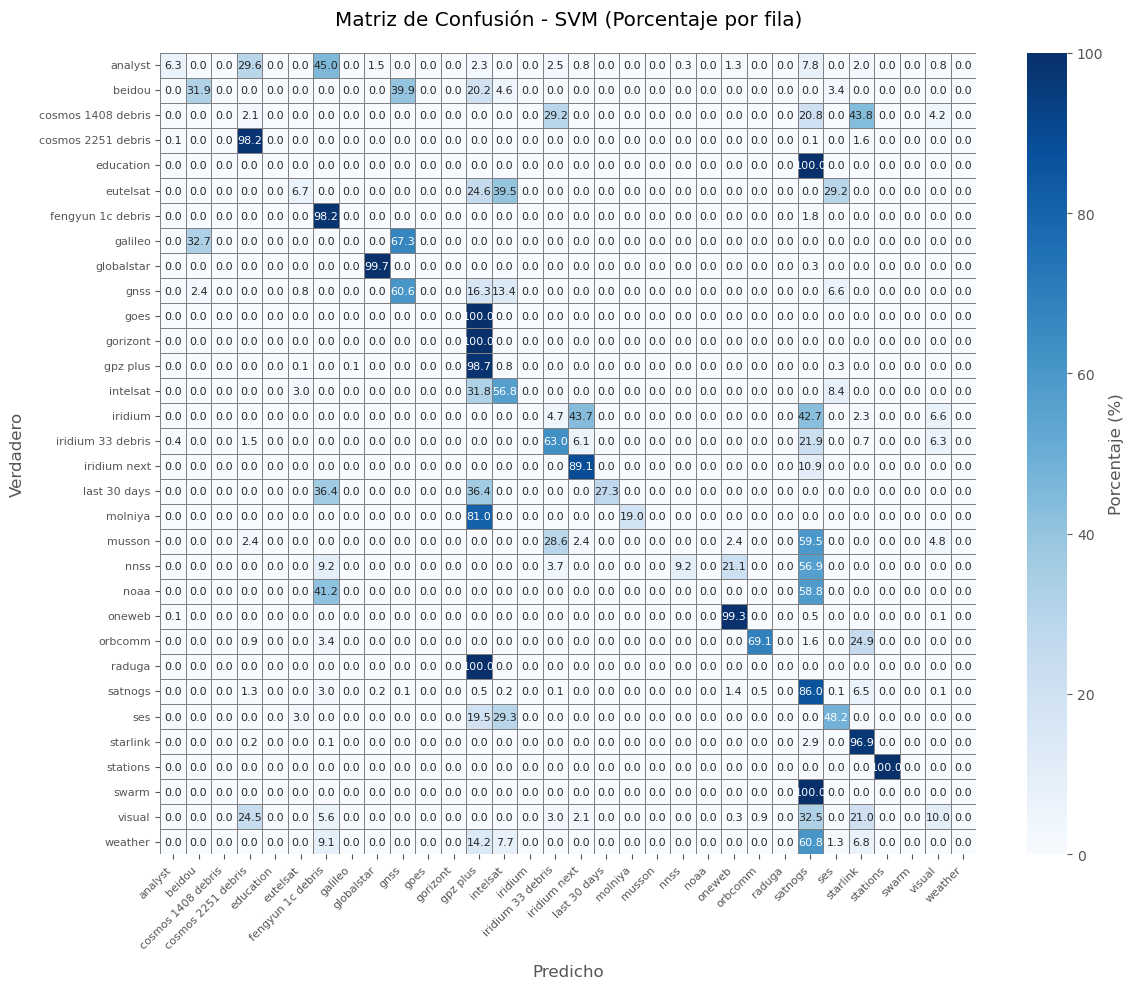


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.937
Clase 'beidou': FAR=0.000, FRR=0.681
Clase 'cosmos 1408 debris': FAR=0.000, FRR=1.000
Clase 'cosmos 2251 debris': FAR=0.009, FRR=0.018
Clase 'education': FAR=0.000, FRR=1.000
Clase 'eutelsat': FAR=0.001, FRR=0.933
Clase 'fengyun 1c debris': FAR=0.013, FRR=0.018
Clase 'galileo': FAR=0.000, FRR=1.000
Clase 'globalstar': FAR=0.000, FRR=0.003
Clase 'gnss': FAR=0.002, FRR=0.394
Clase 'goes': FAR=0.000, FRR=1.000
Clase 'gorizont': FAR=0.000, FRR=1.000
Clase 'gpz plus': FAR=0.019, FRR=0.013
Clase 'intelsat': FAR=0.006, FRR=0.432
Clase 'iridium': FAR=0.000, FRR=1.000
Clase 'iridium 33 debris': FAR=0.002, FRR=0.370
Clase 'iridium next': FAR=0.003, FRR=0.109
Clase 'last 30 days': FAR=0.000, FRR=0.727
Clase 'molniya': FAR=0.000, FRR=0.810
Clase 'musson': FAR=0.000, FRR=1.000
Clase 'nnss': FAR=0.000, FRR=0.908
Clase 'noaa': FAR=0.000, FRR=1.000
Clase 'oneweb': FAR=0.003, FRR=0.007
Clase 'orbcomm': FAR=0.001, FRR=0.309
Clase 'raduga': FAR=0

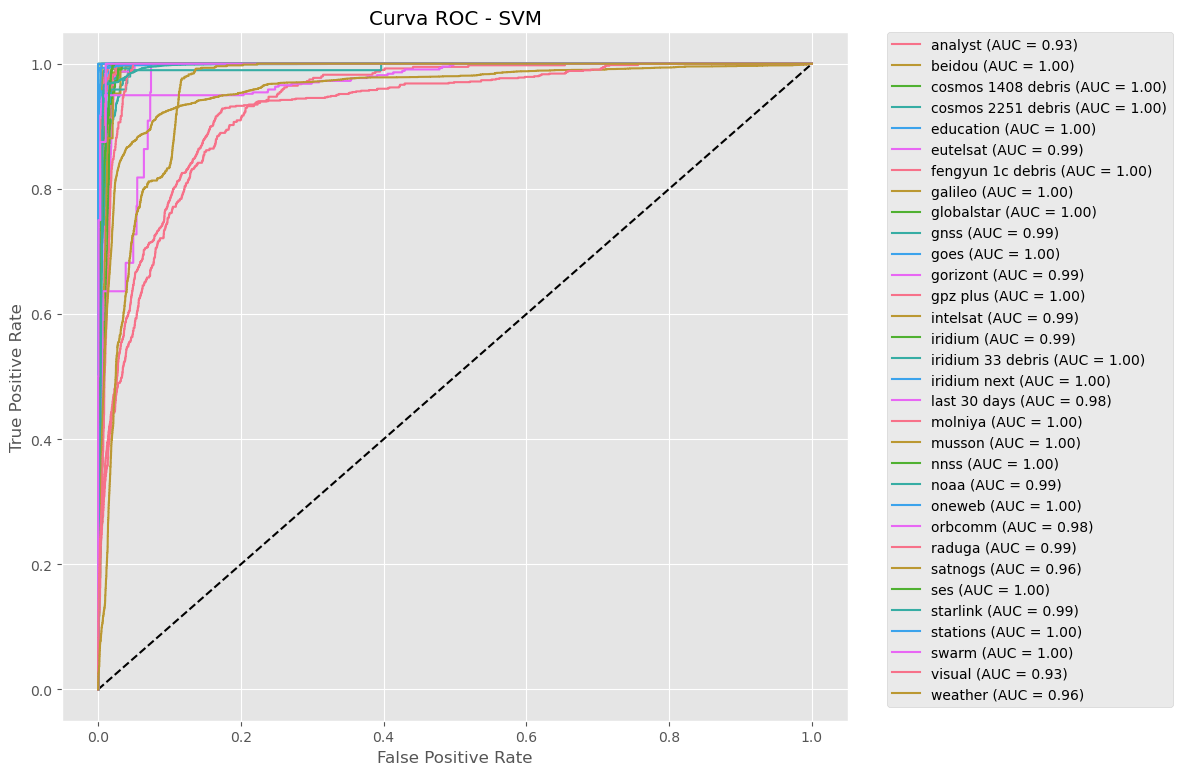


AUC (OvR): 0.989
AUC (OvO): 0.968

--- Evaluación Random Forest (RandomForestClassifier) ---
Accuracy: 0.9576

Classification Report:
                    precision    recall  f1-score   support

           analyst       0.96      0.73      0.83       398
            beidou       0.98      1.00      0.99       238
cosmos 1408 debris       1.00      1.00      1.00        48
cosmos 2251 debris       0.99      1.00      0.99      2724
         education       1.00      1.00      1.00        21
          eutelsat       0.49      0.85      0.62       195
 fengyun 1c debris       0.98      0.99      0.98      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       1.00      0.77      0.87       381
              goes       1.00      1.00      1.00        23
          gorizont       0.38      1.00      0.55       160
          gpz plus       1.00      0.82      0.90      3823
          intelsat      

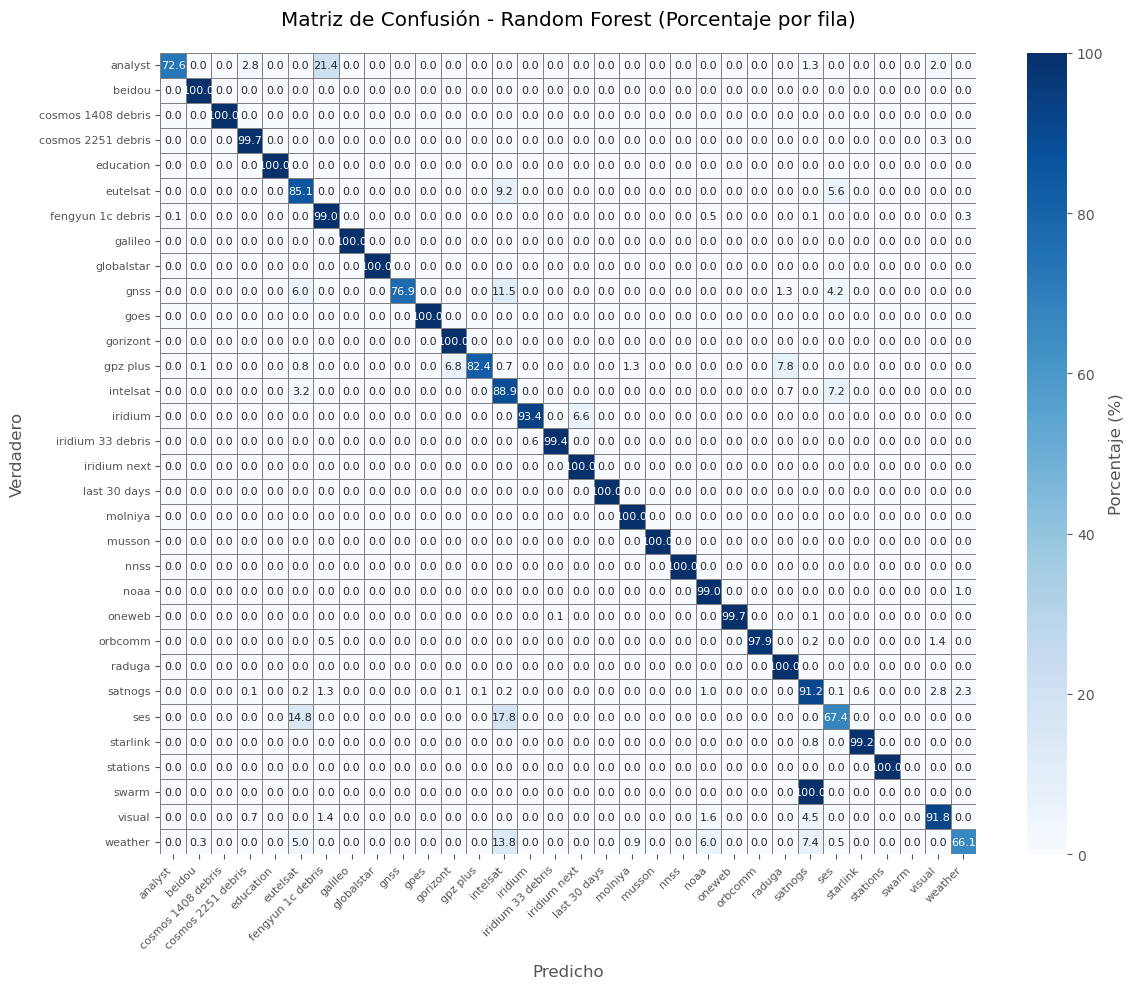


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.274
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.000
Clase 'cosmos 2251 debris': FAR=0.001, FRR=0.003
Clase 'education': FAR=0.000, FRR=0.000
Clase 'eutelsat': FAR=0.003, FRR=0.149
Clase 'fengyun 1c debris': FAR=0.004, FRR=0.010
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.231
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.005, FRR=0.000
Clase 'gpz plus': FAR=0.000, FRR=0.176
Clase 'intelsat': FAR=0.005, FRR=0.111
Clase 'iridium': FAR=0.000, FRR=0.066
Clase 'iridium 33 debris': FAR=0.000, FRR=0.006
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.001, FRR=0.000
Clase 'musson': FAR=0.000, FRR=0.000
Clase 'nnss': FAR=0.000, FRR=0.000
Clase 'noaa': FAR=0.003, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.003
Clase 'orbcomm': FAR=0.000, FRR=0.021
Clase 'raduga': FAR=0

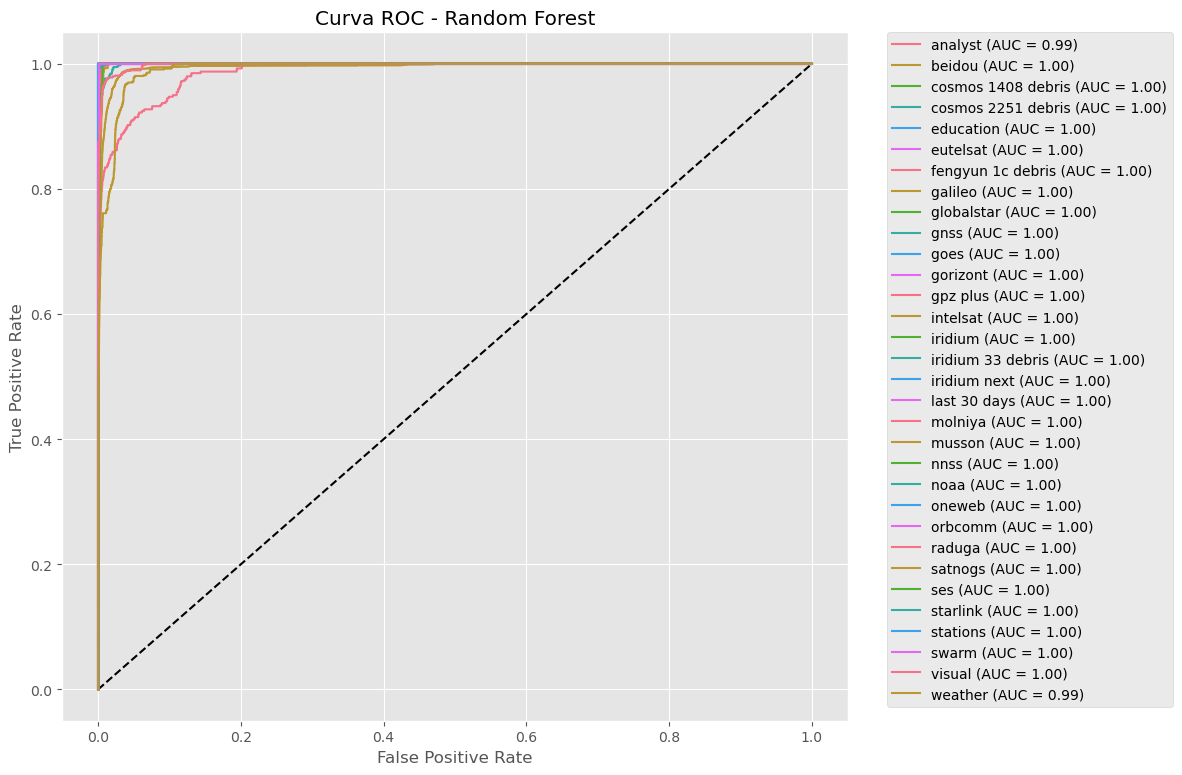


AUC (OvR): 0.999
AUC (OvO): 0.998

--- Evaluación XGBoost (XGBClassifier) ---
Accuracy: 0.9935

Classification Report:
                    precision    recall  f1-score   support

           analyst       1.00      0.80      0.89       398
            beidou       1.00      1.00      1.00       238
cosmos 1408 debris       1.00      0.96      0.98        48
cosmos 2251 debris       1.00      1.00      1.00      2724
         education       1.00      1.00      1.00        21
          eutelsat       0.89      0.91      0.90       195
 fengyun 1c debris       0.99      1.00      1.00      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       0.98      0.95      0.97       381
              goes       1.00      1.00      1.00        23
          gorizont       1.00      0.97      0.99       160
          gpz plus       1.00      1.00      1.00      3823
          intelsat       0.97      0.91

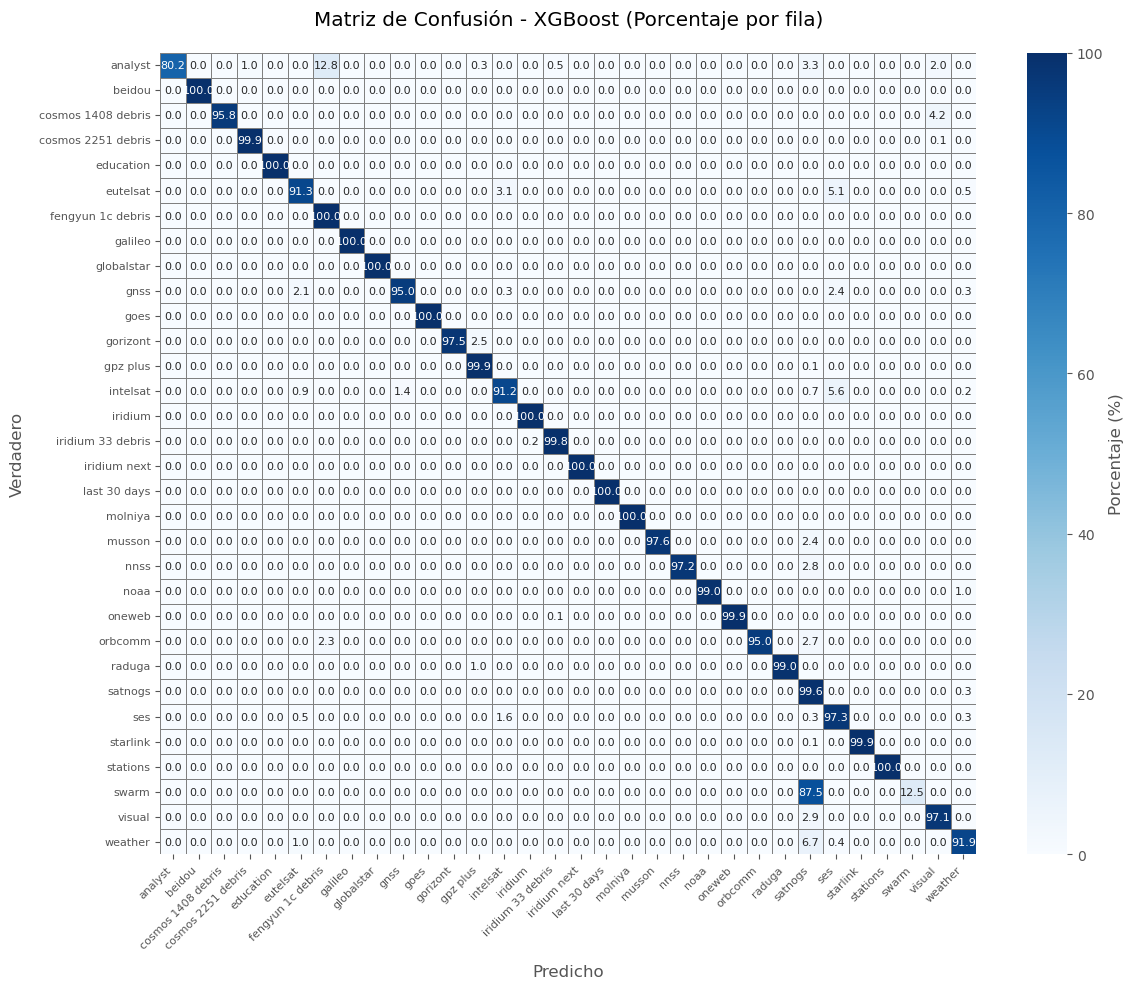


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.198
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.042
Clase 'cosmos 2251 debris': FAR=0.000, FRR=0.001
Clase 'education': FAR=0.000, FRR=0.000
Clase 'eutelsat': FAR=0.000, FRR=0.087
Clase 'fengyun 1c debris': FAR=0.001, FRR=0.000
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.050
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.000, FRR=0.025
Clase 'gpz plus': FAR=0.000, FRR=0.001
Clase 'intelsat': FAR=0.000, FRR=0.088
Clase 'iridium': FAR=0.000, FRR=0.000
Clase 'iridium 33 debris': FAR=0.000, FRR=0.002
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.000, FRR=0.000
Clase 'musson': FAR=0.000, FRR=0.024
Clase 'nnss': FAR=0.000, FRR=0.028
Clase 'noaa': FAR=0.000, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.001
Clase 'orbcomm': FAR=0.000, FRR=0.050
Clase 'raduga': FAR=0

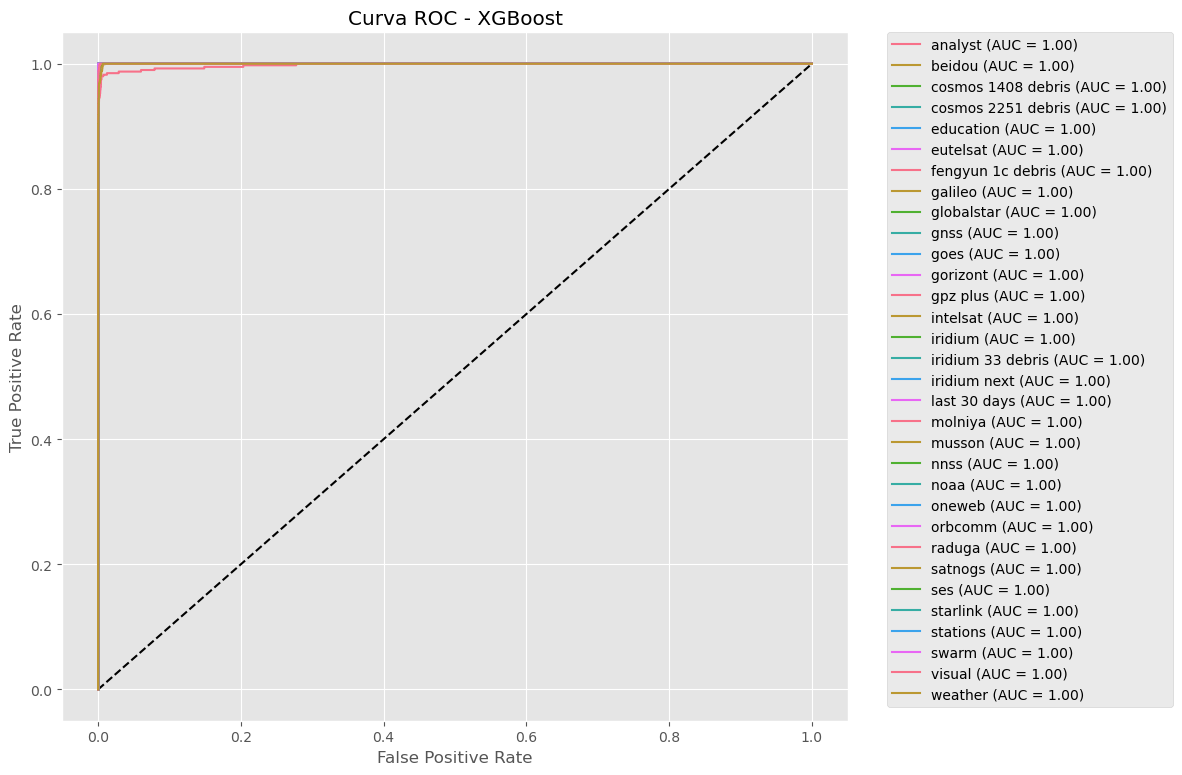


AUC (OvR): 1.000
AUC (OvO): 0.999


In [13]:
def evaluate_model(name, model, X_test, y_test, label_encoder):
    """Función simplificada para evaluar modelos de clasificación"""
    # Configuración inicial
    n_classes = len(label_encoder.classes_)
    labels_idx = np.arange(n_classes)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Métricas principales
    print(f"\n--- Evaluación {name} ({model.__class__.__name__}) ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_,
                              labels=labels_idx, zero_division=0))
    
    # Matriz de confusión (en porcentaje) - VERSIÓN MEJORADA
    plt.figure(figsize=(12, 10))  # Aumentamos el tamaño de la figura
    cm = confusion_matrix(y_test, y_pred, labels=labels_idx)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convertir a porcentaje
    
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
               annot_kws={"size": 8},  # Tamaño de fuente más pequeño
               cbar_kws={'label': 'Porcentaje (%)'},  # Etiqueta para la barra de color
               xticklabels=label_encoder.classes_, 
               yticklabels=label_encoder.classes_,
               linewidths=0.5, linecolor='gray')  # Líneas divisorias
    
    plt.title(f'Matriz de Confusión - {name} (Porcentaje por fila)', pad=20)
    plt.ylabel('Verdadero', labelpad=10)
    plt.xlabel('Predicho', labelpad=10)
    
    # Rotamos las etiquetas y ajustamos tamaño de fuente
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    # Añadimos cuadrícula blanca para mejor legibilidad
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # Métricas FAR y FRR
    print("\nMétricas por clase:")
    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)
        
        far = FP / (FP + TN) if (FP + TN) > 0 else 0
        frr = FN / (TP + FN) if (TP + FN) > 0 else 0
        
        print(f"Clase '{label_encoder.classes_[i]}': FAR={far:.3f}, FRR={frr:.3f}")
    
    # Curvas ROC con leyendas separadas (sin cambios)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {name}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Métricas AUC multiclase
    roc_auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr')
    roc_auc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')
    print(f"\nAUC (OvR): {roc_auc_ovr:.3f}")
    print(f"AUC (OvO): {roc_auc_ovo:.3f}")
    
# Evaluamos todos los modelos
print("\n=== EVALUACIÓN DE MODELOS ===")
for name, model in trained_models.items():
    evaluate_model(name, model, X_val_scaled, y_val_encoded, le)

## 7. Evaluación de Combinación de Modelos

Se exploran diferentes **estrategias para combinar las predicciones** de los modelos base (SVM, Random Forest, XGBoost).

Se evalúan combinaciones basadas en **promedio de probabilidades, máximo/mínimo de probabilidades (normalizadas), promedio ponderado de probabilidades, y votación mayoritaria**, utilizando la misma función `evaluate_model`.


=== COMBINACIÓN Y EVALUACIÓN DE MODELOS COMBINADOS ===

>>> EVALUACIÓN DE COMBINACIONES BASADAS EN PROBABILIDADES <<<

--- Evaluación Combinación - Promedio Probs (CombinedModel) ---
Accuracy: 0.9883

Classification Report:
                    precision    recall  f1-score   support

           analyst       1.00      0.68      0.81       398
            beidou       1.00      1.00      1.00       238
cosmos 1408 debris       1.00      0.96      0.98        48
cosmos 2251 debris       1.00      1.00      1.00      2724
         education       1.00      0.86      0.92        21
          eutelsat       0.90      0.87      0.88       195
 fengyun 1c debris       0.98      1.00      0.99      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       1.00      0.93      0.96       381
              goes       1.00      1.00      1.00        23
          gorizont       1.00      0.97      0.99     

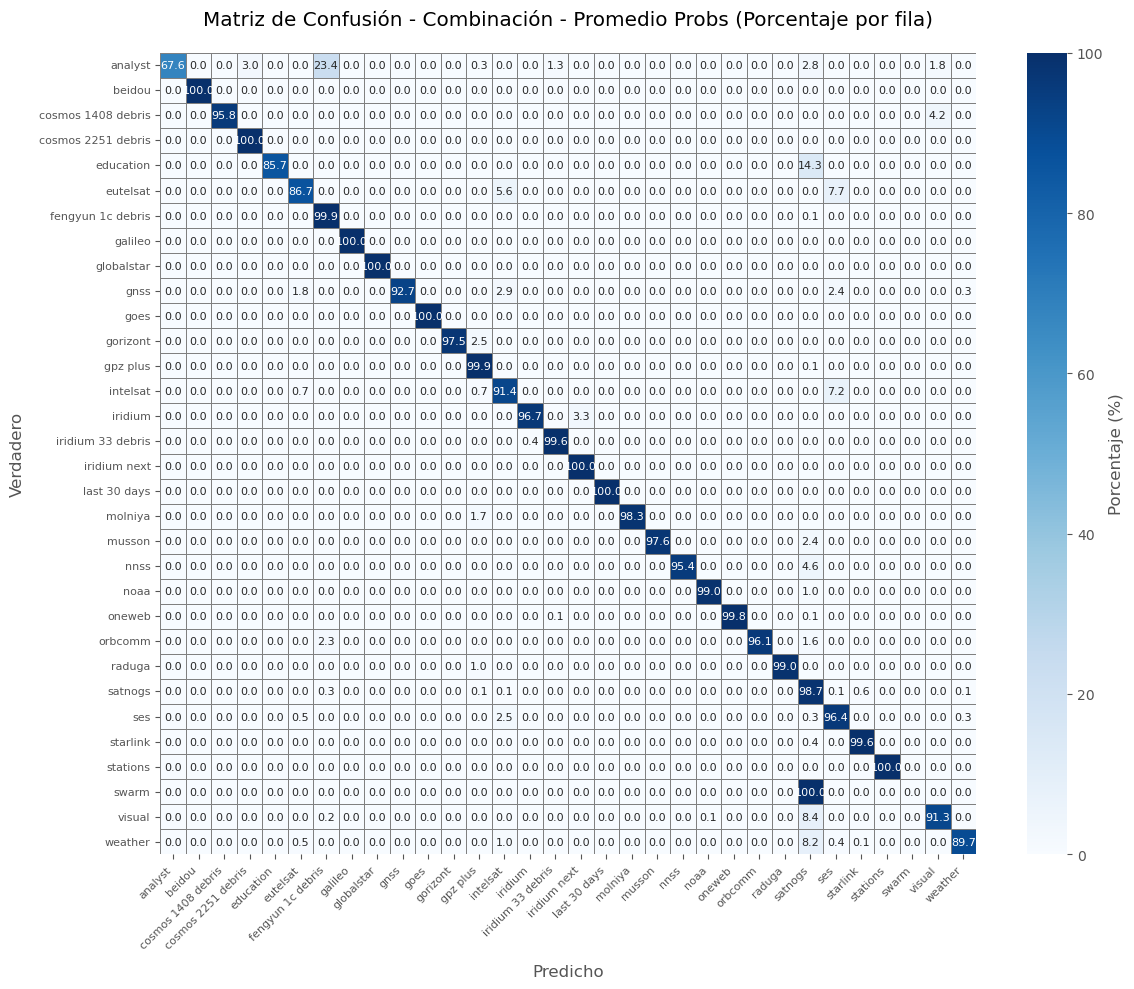


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.324
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.042
Clase 'cosmos 2251 debris': FAR=0.000, FRR=0.000
Clase 'education': FAR=0.000, FRR=0.143
Clase 'eutelsat': FAR=0.000, FRR=0.133
Clase 'fengyun 1c debris': FAR=0.003, FRR=0.001
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.073
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.000, FRR=0.025
Clase 'gpz plus': FAR=0.000, FRR=0.001
Clase 'intelsat': FAR=0.001, FRR=0.086
Clase 'iridium': FAR=0.000, FRR=0.033
Clase 'iridium 33 debris': FAR=0.000, FRR=0.004
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.000, FRR=0.017
Clase 'musson': FAR=0.000, FRR=0.024
Clase 'nnss': FAR=0.000, FRR=0.046
Clase 'noaa': FAR=0.000, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.002
Clase 'orbcomm': FAR=0.000, FRR=0.039
Clase 'raduga': FAR=0

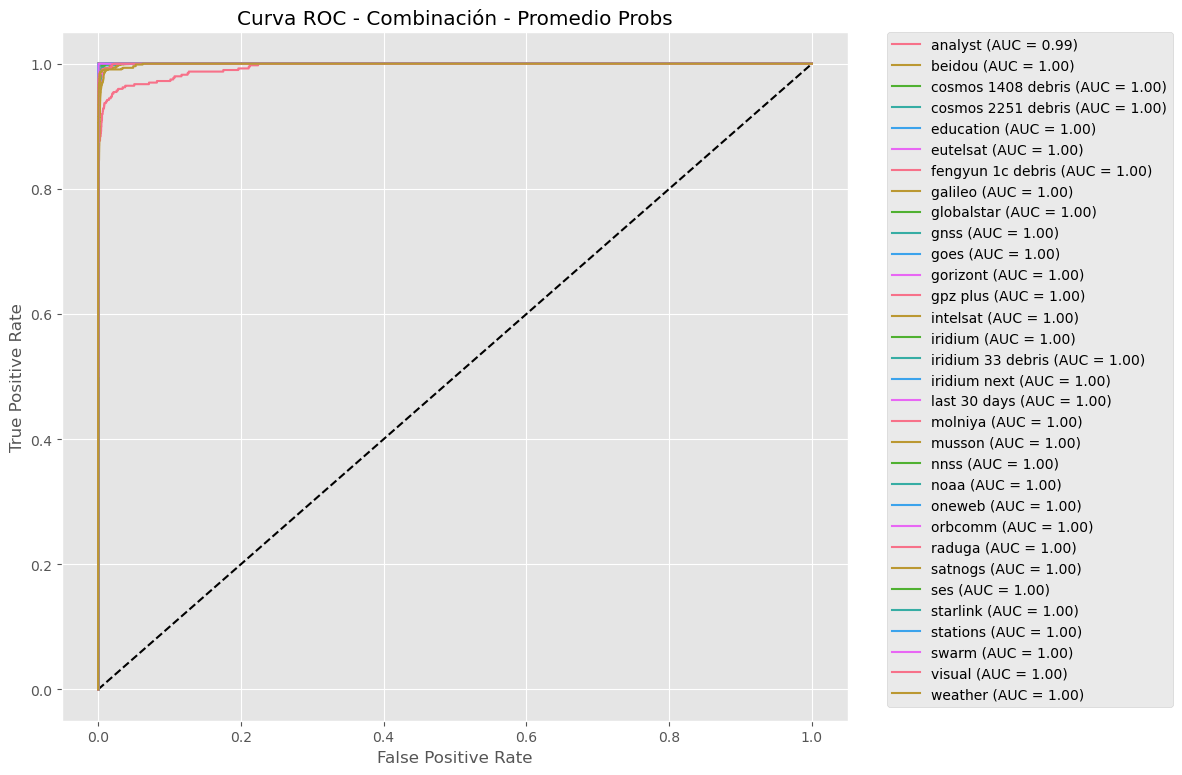


AUC (OvR): 1.000
AUC (OvO): 0.999

--- Evaluación Combinación - Máximo Probs (Normalizado) (CombinedModel) ---
Accuracy: 0.9891

Classification Report:
                    precision    recall  f1-score   support

           analyst       1.00      0.70      0.82       398
            beidou       1.00      1.00      1.00       238
cosmos 1408 debris       1.00      0.92      0.96        48
cosmos 2251 debris       1.00      1.00      1.00      2724
         education       1.00      0.86      0.92        21
          eutelsat       0.89      0.90      0.90       195
 fengyun 1c debris       0.98      1.00      0.99      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       0.98      0.94      0.96       381
              goes       1.00      1.00      1.00        23
          gorizont       1.00      0.97      0.99       160
          gpz plus       0.99      1.00      1.00      3823
      

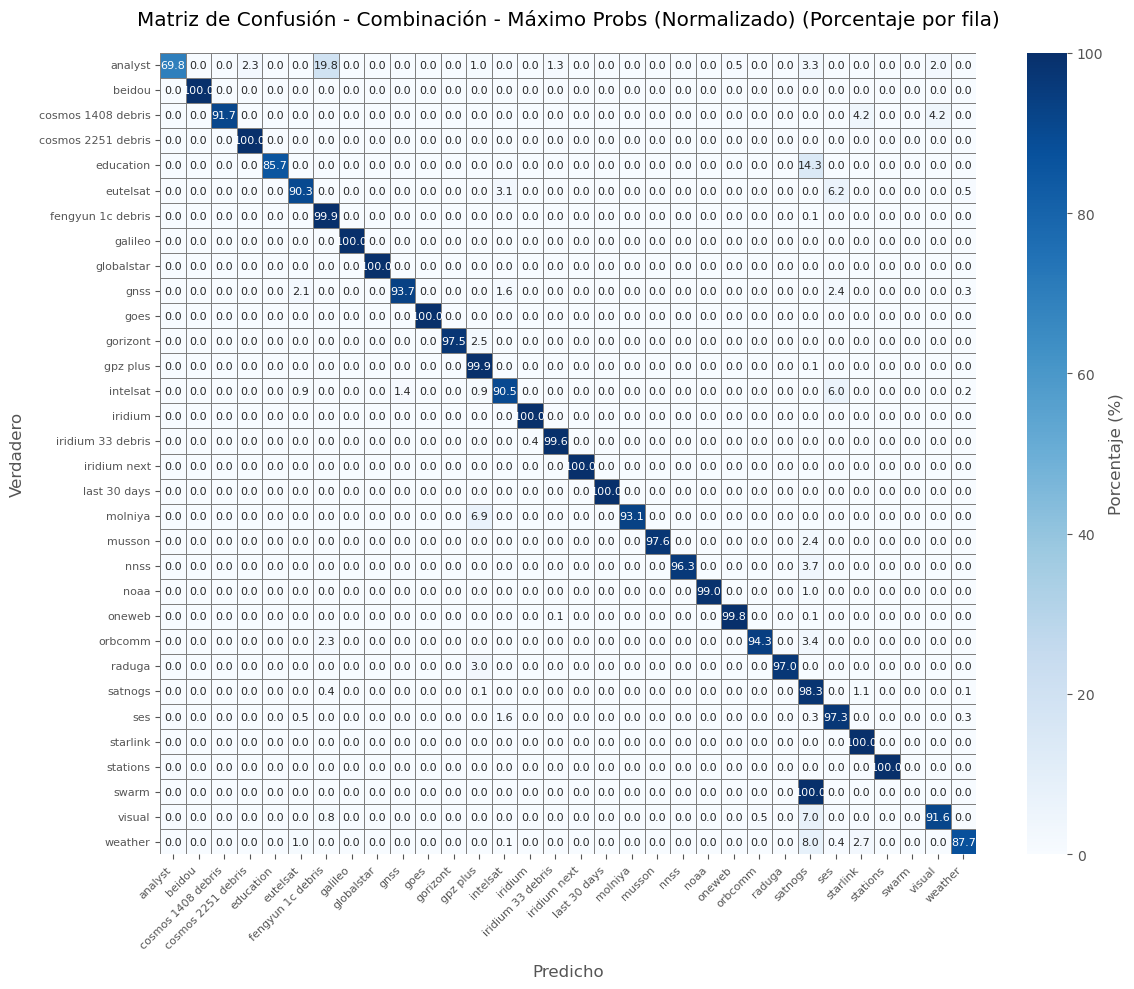


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.302
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.083
Clase 'cosmos 2251 debris': FAR=0.000, FRR=0.000
Clase 'education': FAR=0.000, FRR=0.143
Clase 'eutelsat': FAR=0.000, FRR=0.097
Clase 'fengyun 1c debris': FAR=0.003, FRR=0.001
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.063
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.000, FRR=0.025
Clase 'gpz plus': FAR=0.001, FRR=0.001
Clase 'intelsat': FAR=0.000, FRR=0.095
Clase 'iridium': FAR=0.000, FRR=0.000
Clase 'iridium 33 debris': FAR=0.000, FRR=0.004
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.000, FRR=0.069
Clase 'musson': FAR=0.000, FRR=0.024
Clase 'nnss': FAR=0.000, FRR=0.037
Clase 'noaa': FAR=0.000, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.002
Clase 'orbcomm': FAR=0.000, FRR=0.057
Clase 'raduga': FAR=0

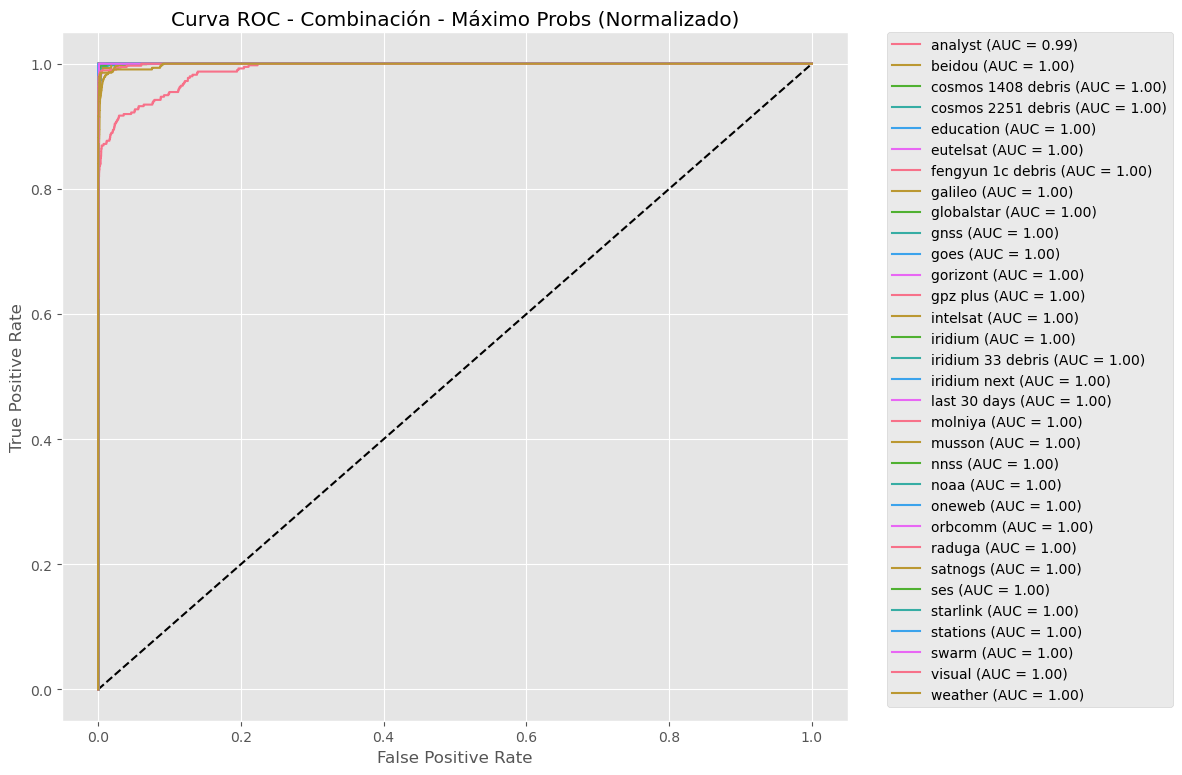


AUC (OvR): 1.000
AUC (OvO): 0.999

--- Evaluación Combinación - Mínimo Probs (Normalizado) (CombinedModel) ---
Accuracy: 0.9800

Classification Report:
                    precision    recall  f1-score   support

           analyst       0.97      0.52      0.67       398
            beidou       1.00      1.00      1.00       238
cosmos 1408 debris       1.00      0.69      0.81        48
cosmos 2251 debris       0.99      1.00      1.00      2724
         education       1.00      0.29      0.44        21
          eutelsat       0.84      0.70      0.76       195
 fengyun 1c debris       0.98      1.00      0.99      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       0.98      0.88      0.93       381
              goes       0.91      0.87      0.89        23
          gorizont       0.99      0.93      0.96       160
          gpz plus       0.98      1.00      0.99      3823
      

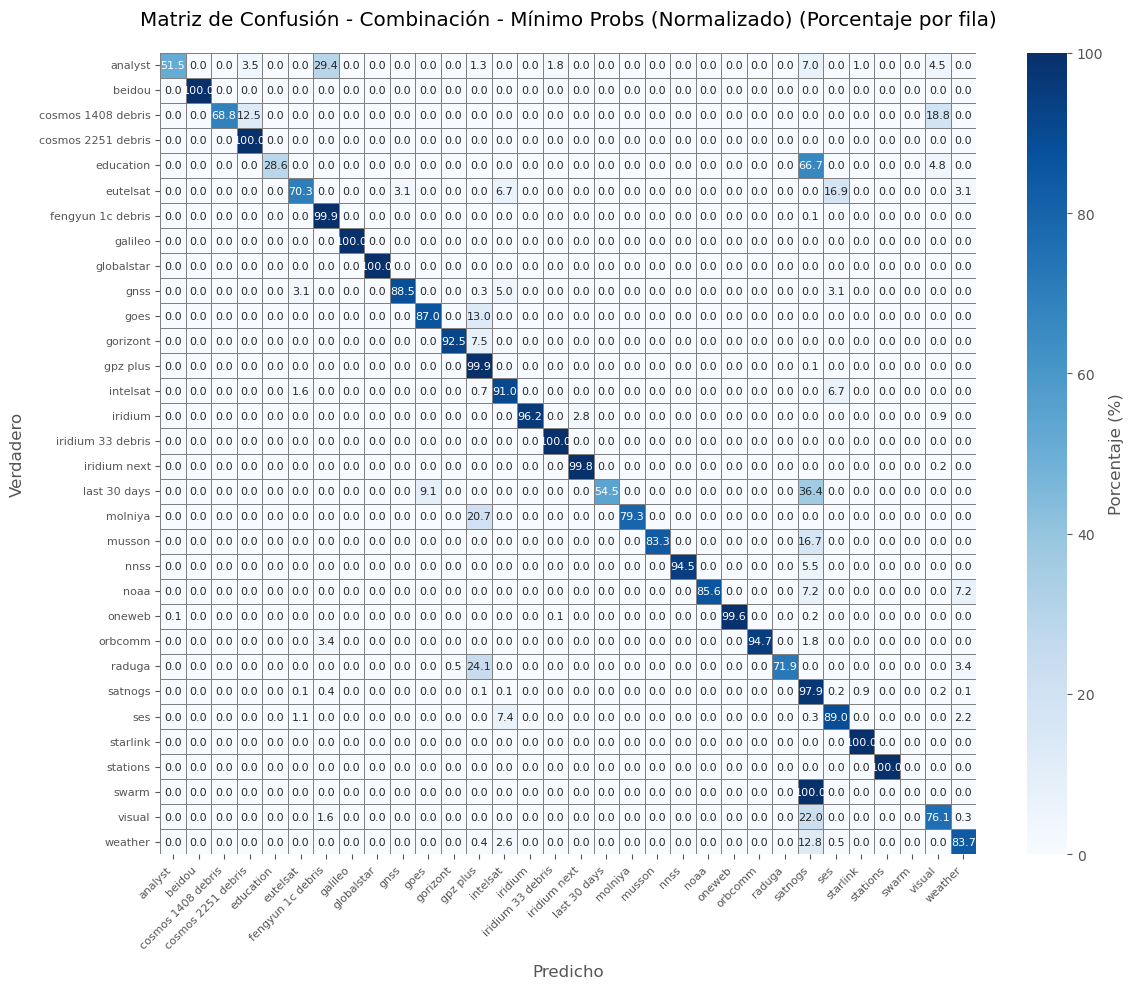


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.485
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.312
Clase 'cosmos 2251 debris': FAR=0.000, FRR=0.000
Clase 'education': FAR=0.000, FRR=0.714
Clase 'eutelsat': FAR=0.000, FRR=0.297
Clase 'fengyun 1c debris': FAR=0.004, FRR=0.001
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.115
Clase 'goes': FAR=0.000, FRR=0.130
Clase 'gorizont': FAR=0.000, FRR=0.075
Clase 'gpz plus': FAR=0.002, FRR=0.001
Clase 'intelsat': FAR=0.002, FRR=0.090
Clase 'iridium': FAR=0.000, FRR=0.038
Clase 'iridium 33 debris': FAR=0.000, FRR=0.000
Clase 'iridium next': FAR=0.000, FRR=0.002
Clase 'last 30 days': FAR=0.000, FRR=0.455
Clase 'molniya': FAR=0.000, FRR=0.207
Clase 'musson': FAR=0.000, FRR=0.167
Clase 'nnss': FAR=0.000, FRR=0.055
Clase 'noaa': FAR=0.000, FRR=0.144
Clase 'oneweb': FAR=0.000, FRR=0.004
Clase 'orbcomm': FAR=0.000, FRR=0.053
Clase 'raduga': FAR=0

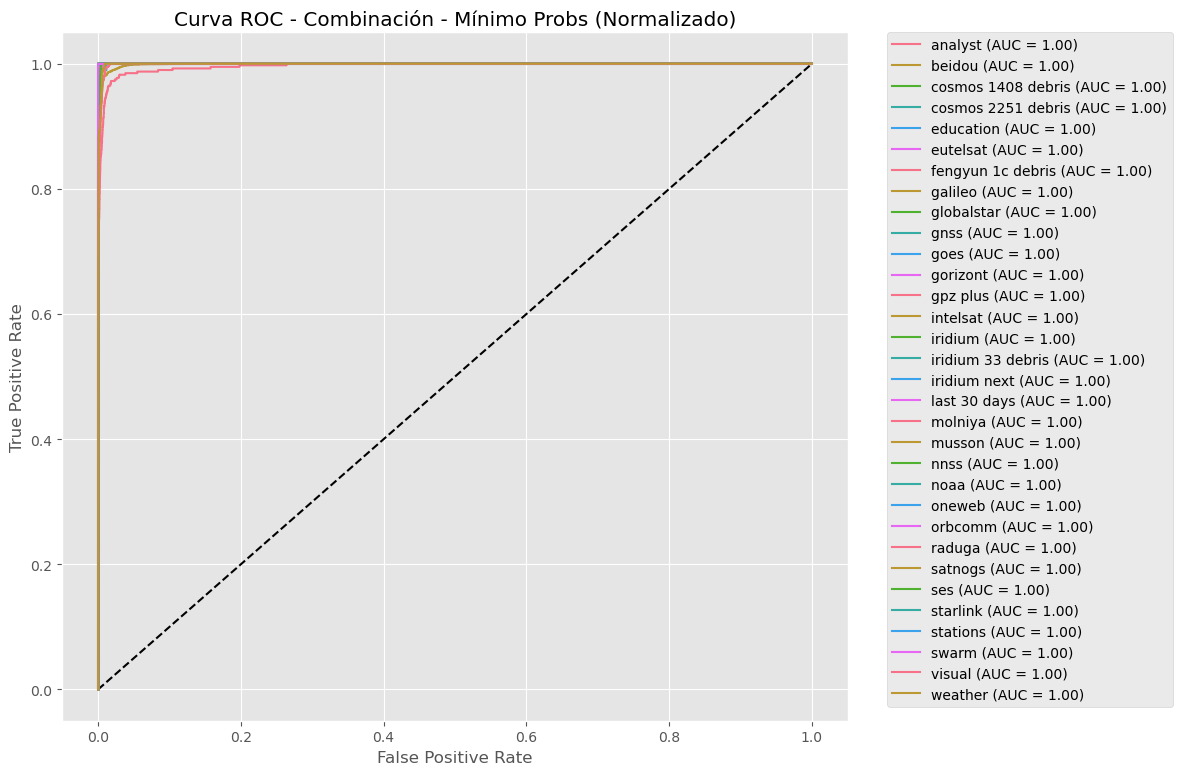


AUC (OvR): 1.000
AUC (OvO): 0.998

--- Evaluación Combinación - Promedio Ponderado Probs (CombinedModel) ---
Accuracy: 0.9925

Classification Report:
                    precision    recall  f1-score   support

           analyst       1.00      0.76      0.86       398
            beidou       1.00      1.00      1.00       238
cosmos 1408 debris       1.00      0.96      0.98        48
cosmos 2251 debris       1.00      1.00      1.00      2724
         education       1.00      0.86      0.92        21
          eutelsat       0.87      0.92      0.90       195
 fengyun 1c debris       0.99      1.00      0.99      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       0.99      0.93      0.96       381
              goes       1.00      1.00      1.00        23
          gorizont       1.00      0.97      0.99       160
          gpz plus       1.00      1.00      1.00      3823
        

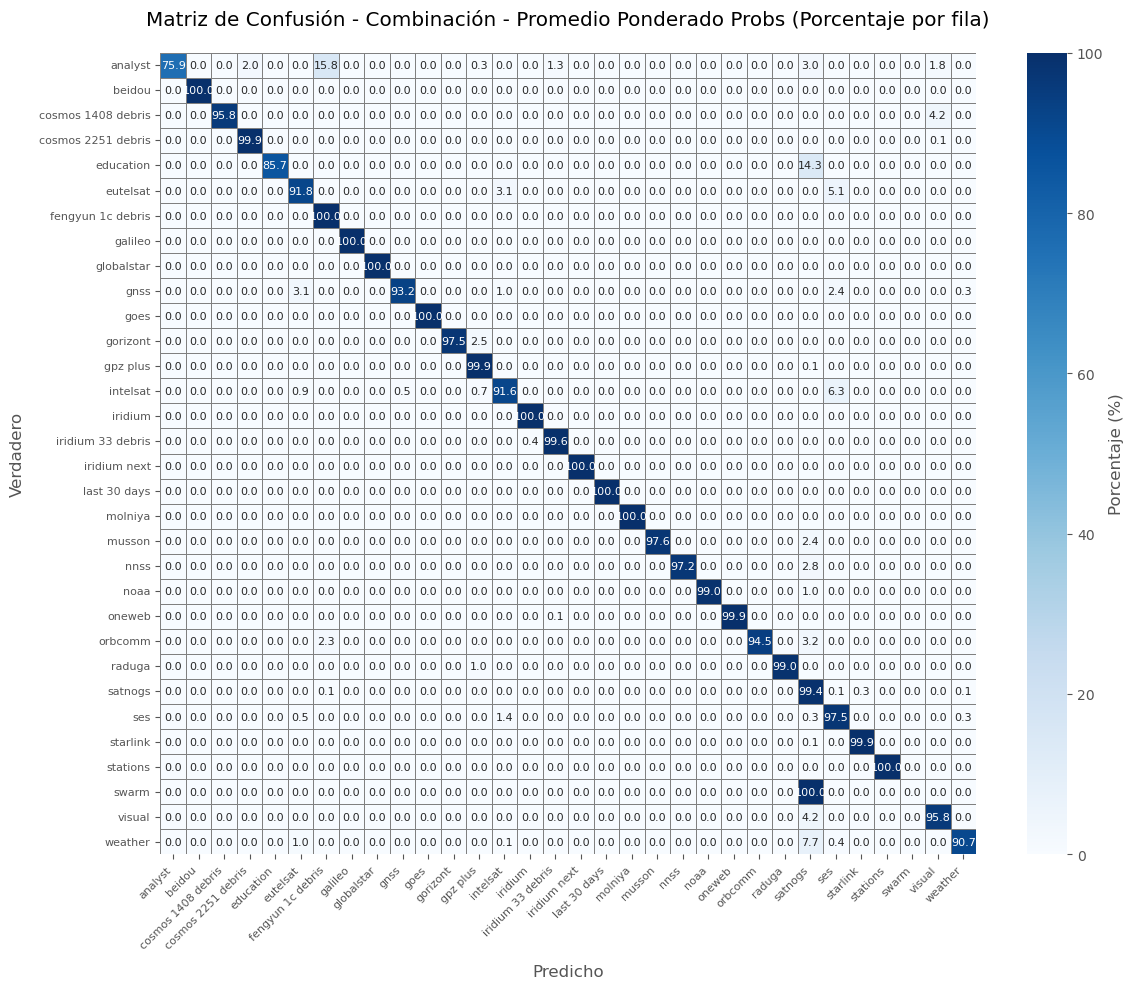


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.241
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.042
Clase 'cosmos 2251 debris': FAR=0.000, FRR=0.001
Clase 'education': FAR=0.000, FRR=0.143
Clase 'eutelsat': FAR=0.000, FRR=0.082
Clase 'fengyun 1c debris': FAR=0.002, FRR=0.000
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.068
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.000, FRR=0.025
Clase 'gpz plus': FAR=0.000, FRR=0.001
Clase 'intelsat': FAR=0.000, FRR=0.084
Clase 'iridium': FAR=0.000, FRR=0.000
Clase 'iridium 33 debris': FAR=0.000, FRR=0.004
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.000, FRR=0.000
Clase 'musson': FAR=0.000, FRR=0.024
Clase 'nnss': FAR=0.000, FRR=0.028
Clase 'noaa': FAR=0.000, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.001
Clase 'orbcomm': FAR=0.000, FRR=0.055
Clase 'raduga': FAR=0

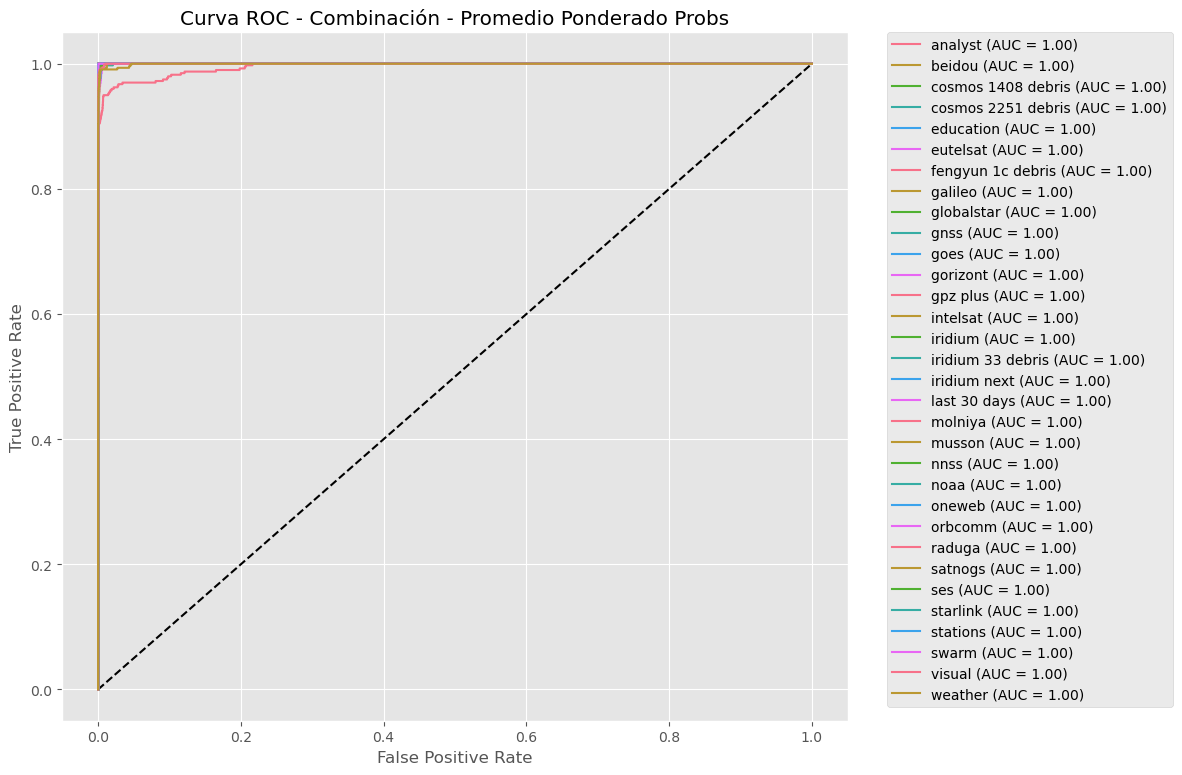


AUC (OvR): 1.000
AUC (OvO): 0.999

>>> EVALUACIÓN DE COMBINACIÓN POR VOTACIÓN MAYORITARIA <<<

--- Evaluación Combinación - Votación Mayoritaria (VotingModel) ---
Accuracy: 0.9774

Classification Report:
                    precision    recall  f1-score   support

           analyst       0.99      0.71      0.83       398
            beidou       0.99      1.00      1.00       238
cosmos 1408 debris       1.00      1.00      1.00        48
cosmos 2251 debris       0.97      1.00      0.99      2724
         education       1.00      1.00      1.00        21
          eutelsat       0.58      0.86      0.69       195
 fengyun 1c debris       0.97      1.00      0.98      7670
           galileo       1.00      1.00      1.00        49
        globalstar       1.00      1.00      1.00       583
              gnss       0.99      0.84      0.91       381
              goes       1.00      1.00      1.00        23
          gorizont       0.97      0.97      0.97       160
          gpz 

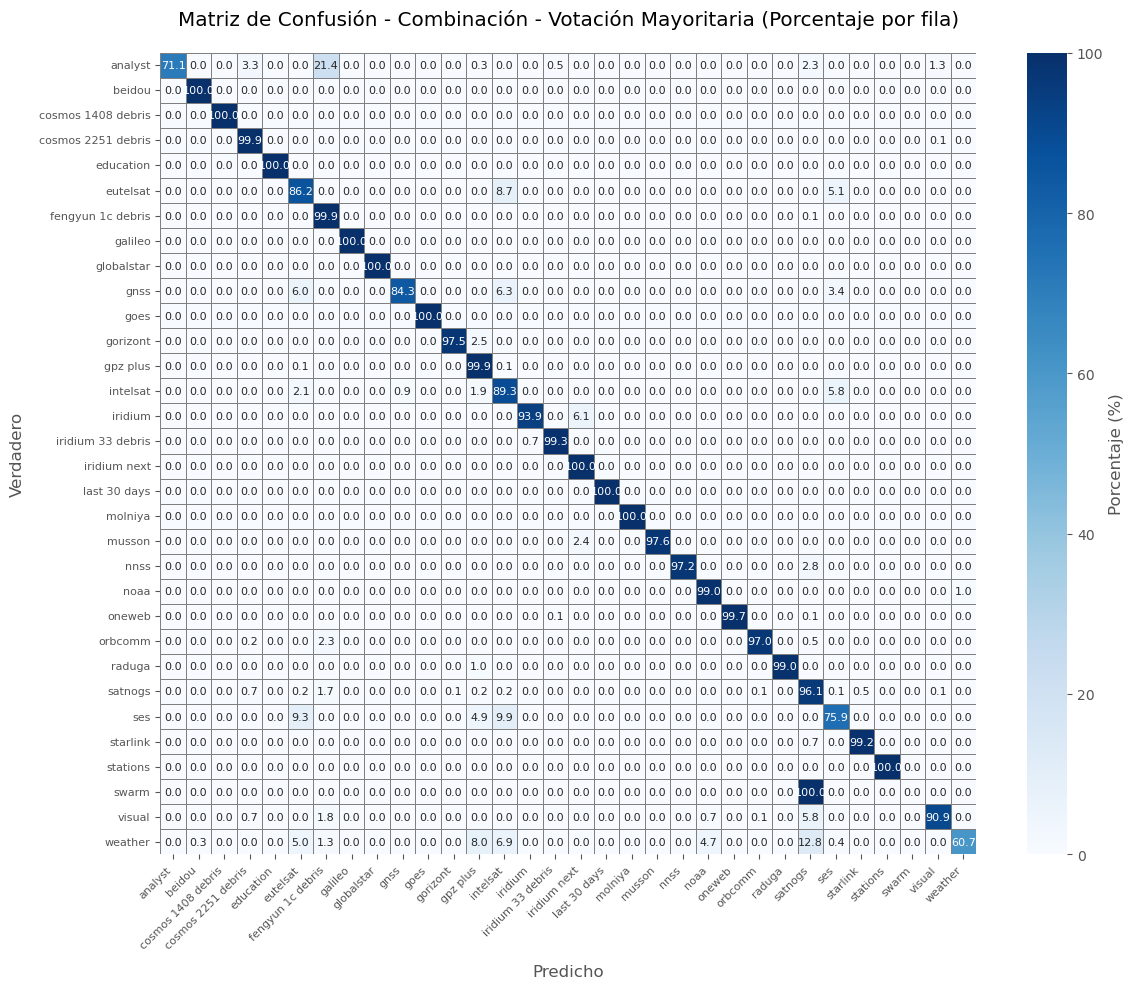


Métricas por clase:
Clase 'analyst': FAR=0.000, FRR=0.289
Clase 'beidou': FAR=0.000, FRR=0.000
Clase 'cosmos 1408 debris': FAR=0.000, FRR=0.000
Clase 'cosmos 2251 debris': FAR=0.001, FRR=0.001
Clase 'education': FAR=0.000, FRR=0.000
Clase 'eutelsat': FAR=0.002, FRR=0.138
Clase 'fengyun 1c debris': FAR=0.005, FRR=0.001
Clase 'galileo': FAR=0.000, FRR=0.000
Clase 'globalstar': FAR=0.000, FRR=0.000
Clase 'gnss': FAR=0.000, FRR=0.157
Clase 'goes': FAR=0.000, FRR=0.000
Clase 'gorizont': FAR=0.000, FRR=0.025
Clase 'gpz plus': FAR=0.002, FRR=0.001
Clase 'intelsat': FAR=0.003, FRR=0.107
Clase 'iridium': FAR=0.000, FRR=0.061
Clase 'iridium 33 debris': FAR=0.000, FRR=0.007
Clase 'iridium next': FAR=0.000, FRR=0.000
Clase 'last 30 days': FAR=0.000, FRR=0.000
Clase 'molniya': FAR=0.000, FRR=0.000
Clase 'musson': FAR=0.000, FRR=0.024
Clase 'nnss': FAR=0.000, FRR=0.028
Clase 'noaa': FAR=0.001, FRR=0.010
Clase 'oneweb': FAR=0.000, FRR=0.003
Clase 'orbcomm': FAR=0.000, FRR=0.030
Clase 'raduga': FAR=0

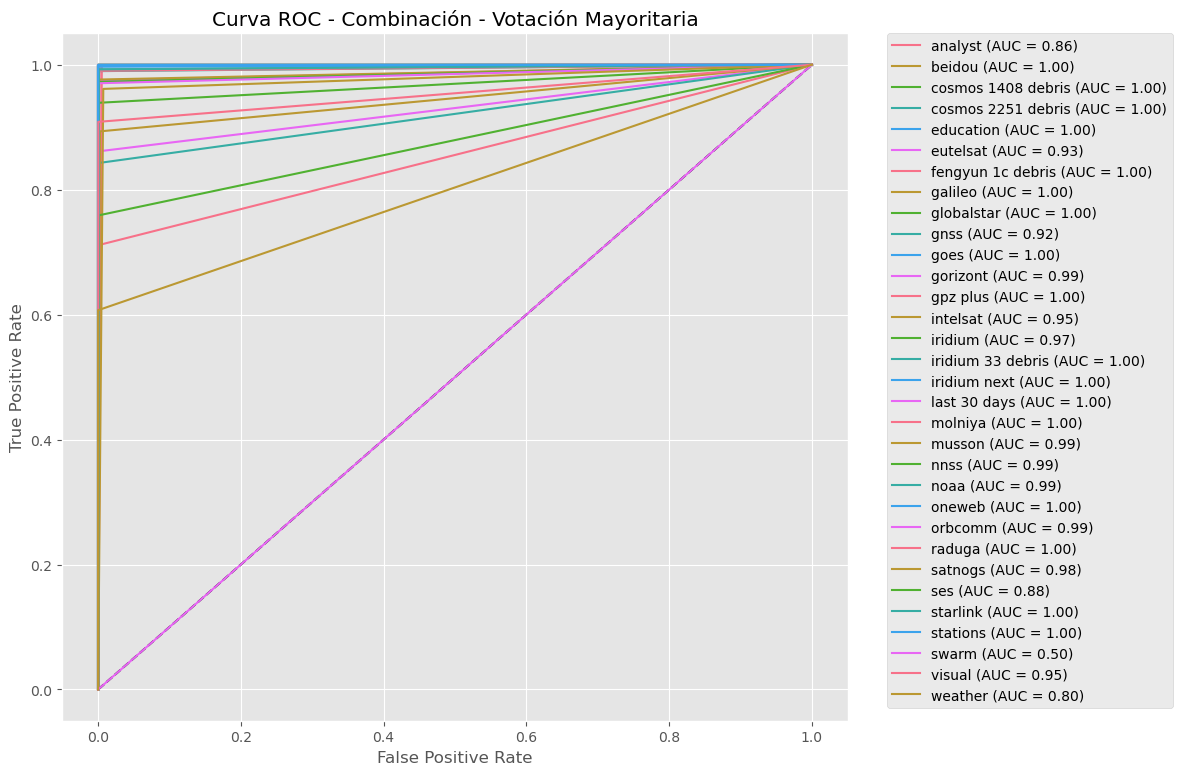


AUC (OvR): 0.958
AUC (OvO): 0.957


In [14]:
# Celda para modelos combinados
print("\n=== COMBINACIÓN Y EVALUACIÓN DE MODELOS COMBINADOS ===")

# Seleccionamos modelos base para combinar
model_names_to_combine = ['SVM', 'Random Forest', 'XGBoost'] # Ajustar según modelos entrenados
model_list_to_combine = []
for name in model_names_to_combine:
    if name in trained_models:
        model_list_to_combine.append(trained_models[name])
    else:
        print(f"Advertencia: Modelo '{name}' no encontrado, se omitirá de la combinación.")

if not model_list_to_combine:
    print("Error: No hay modelos válidos para combinar.")
else:

    # Obtenemos predicciones y probabilidades de los modelos base sobre X_val_scaled
    probs_from_base_models = []
    can_do_prob_combination = True
    for model_idx, model_base in enumerate(model_list_to_combine):
        if hasattr(model_base, 'predict_proba'):
            probs_from_base_models.append(model_base.predict_proba(X_val_scaled))
        else:
            print(f"Advertencia: Modelo {model_names_to_combine[model_idx]} no tiene predict_proba. Afectará combinaciones de probabilidad.")
            can_do_prob_combination = False
            

    preds_from_base_models = np.array([model.predict(X_val_scaled) for model in model_list_to_combine])

    # Clases contenedoras (Wrappers) para modelos combinados
    class CombinedModel(BaseEstimator, ClassifierMixin):
        def __init__(self, combined_probs, actual_classes_array):
            self.probs = combined_probs
            self.preds = np.argmax(self.probs, axis=1)
            self.classes_ = actual_classes_array 
            
        def predict(self, X): return self.preds
        def predict_proba(self, X): return self.probs

    class VotingModel(BaseEstimator, ClassifierMixin):
        def __init__(self, majority_vote_predictions, actual_classes_array):
            self.preds = majority_vote_predictions
            self.classes_ = actual_classes_array 

        def predict(self, X): return self.preds
        def predict_proba(self, X): 
            proba = np.zeros((len(self.preds), len(self.classes_)))
            proba[np.arange(len(self.preds)), self.preds] = 1.0
            return proba

    # Aplicamos reglas de combinación y evaluamos
    actual_classes = le.classes_ 

    # 1. Combinaciones basadas en Probabilidades
    if can_do_prob_combination and probs_from_base_models:
        print("\n>>> EVALUACIÓN DE COMBINACIONES BASADAS EN PROBABILIDADES <<<")
        
        avg_probs = np.mean(probs_from_base_models, axis=0)
        evaluate_model("Combinación - Promedio Probs", CombinedModel(avg_probs, actual_classes), X_val_scaled, y_val_encoded, le)

        max_p = np.max(probs_from_base_models, axis=0)
        max_p_sum = np.sum(max_p, axis=1, keepdims=True)
        max_p_normalized = np.divide(max_p, max_p_sum, out=np.zeros_like(max_p), where=max_p_sum!=0) 
        evaluate_model("Combinación - Máximo Probs (Normalizado)", CombinedModel(max_p_normalized, actual_classes), X_val_scaled, y_val_encoded, le)

        min_p = np.min(probs_from_base_models, axis=0)
        min_p_sum = np.sum(min_p, axis=1, keepdims=True)
        min_p_normalized = np.divide(min_p, min_p_sum, out=np.zeros_like(min_p), where=min_p_sum!=0) 
        evaluate_model("Combinación - Mínimo Probs (Normalizado)", CombinedModel(min_p_normalized, actual_classes), X_val_scaled, y_val_encoded, le)

        weights = [0.2, 0.3, 0.5] # Ajustar pesos al orden de model_list_to_combine
        if len(weights) == len(probs_from_base_models): 
            weighted_probs = np.tensordot(weights, probs_from_base_models, axes=(0,0))
            evaluate_model("Combinación - Promedio Ponderado Probs", CombinedModel(weighted_probs, actual_classes), X_val_scaled, y_val_encoded, le)
        elif probs_from_base_models: 
             print(f"Advertencia: Número de pesos ({len(weights)}) no coincide con modelos con probs ({len(probs_from_base_models)}). Saltando ponderada.")
    
    elif not probs_from_base_models and model_list_to_combine : 
        print("Advertencia: Ningún modelo seleccionado para combinación tiene predict_proba. Saltando combinaciones de probabilidad.")


    # 2. Combinación por Votación Mayoritaria
    if preds_from_base_models.size > 0:
        print("\n>>> EVALUACIÓN DE COMBINACIÓN POR VOTACIÓN MAYORITARIA <<<")
        maj_vote_preds = np.apply_along_axis(lambda x: np.bincount(x, minlength=len(actual_classes)).argmax(), axis=0, arr=preds_from_base_models)
        evaluate_model("Combinación - Votación Mayoritaria", VotingModel(maj_vote_preds, actual_classes), X_val_scaled, y_val_encoded, le)
    elif model_list_to_combine: 
        print("Advertencia: No se pudieron obtener predicciones de los modelos base para votación.")

## 8. Análisis de las Características

Se analiza la **importancia relativa de cada característica** para los modelos individuales y para las combinaciones. Los resultados se **visualizan en gráficos de barras** para facilitar la interpretación de qué características son más influyentes.


=== IMPORTANCIA PARA MODELOS INDIVIDUALES ===
SVM no soporta análisis de importancia estándar


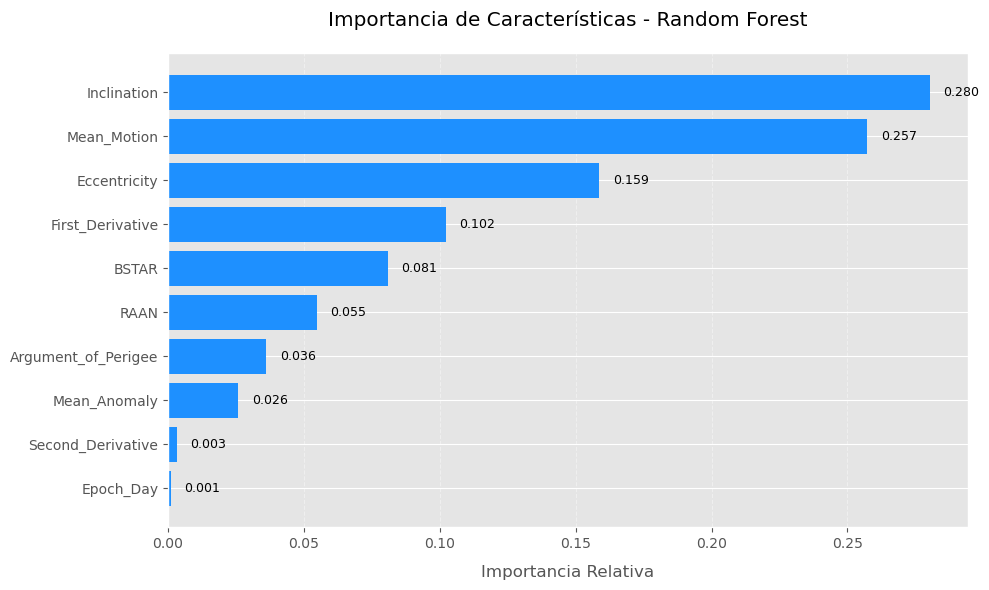

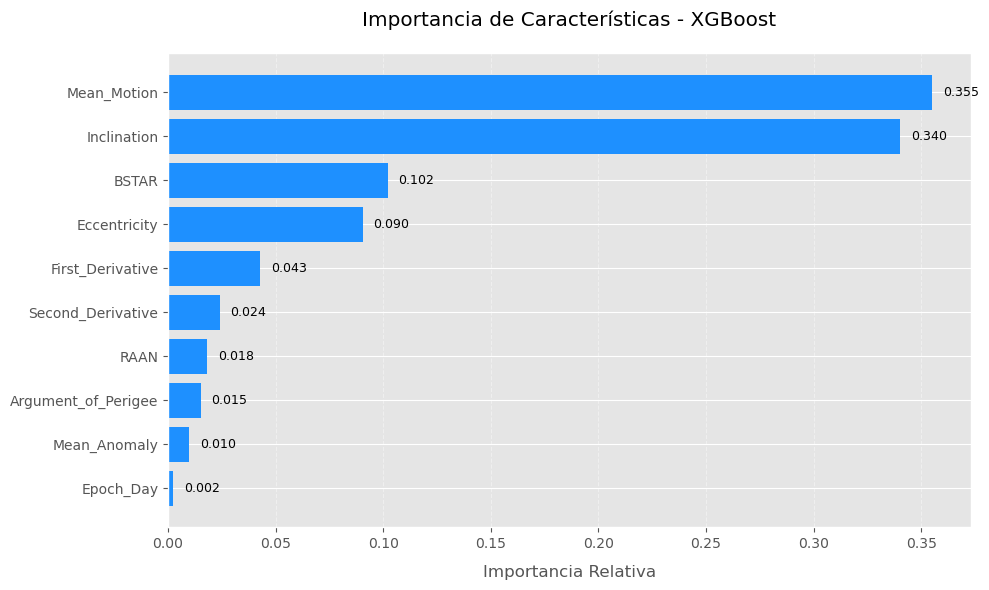


=== IMPORTANCIA PARA COMBINACIONES ===


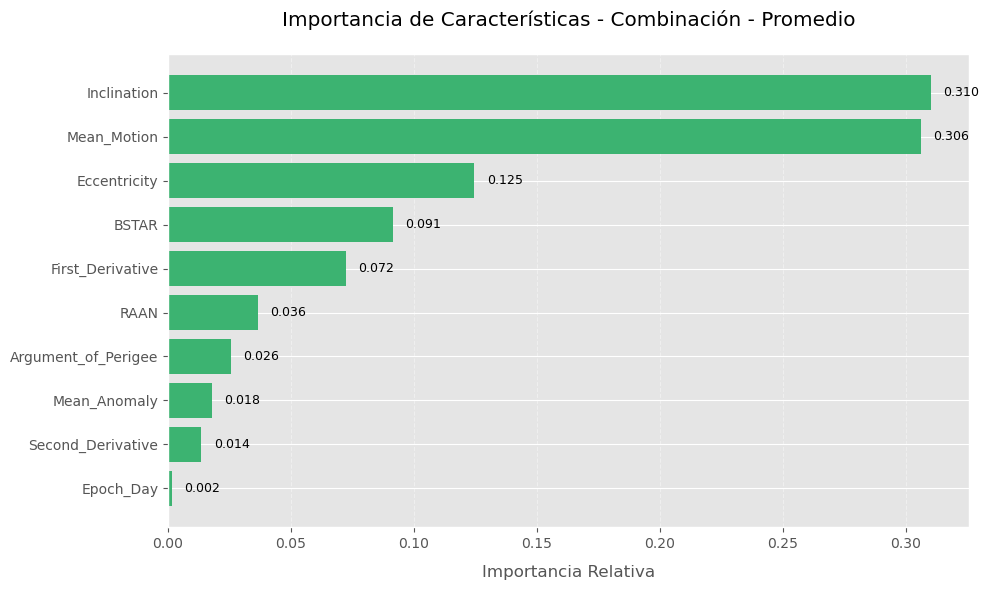

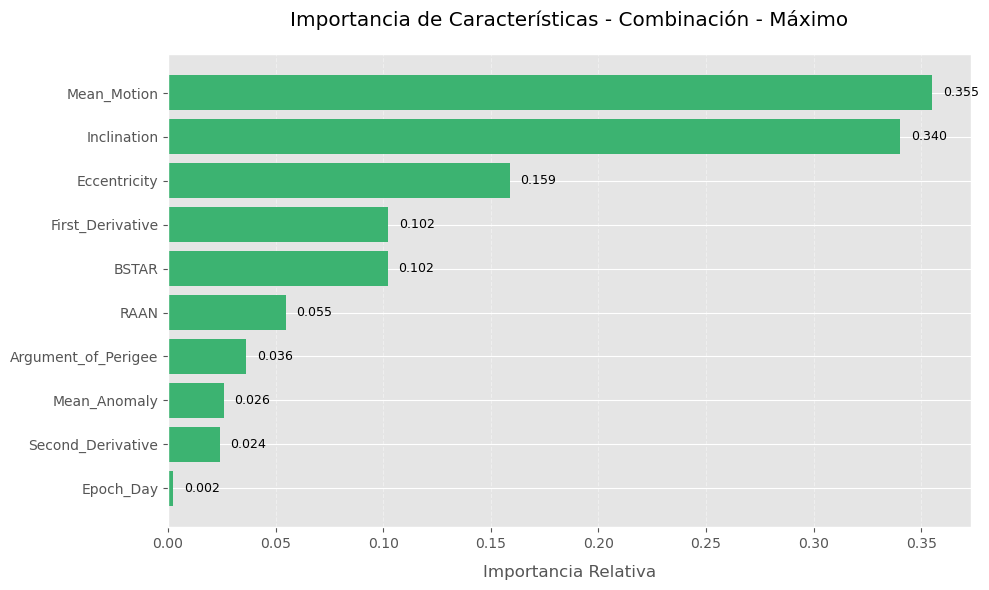

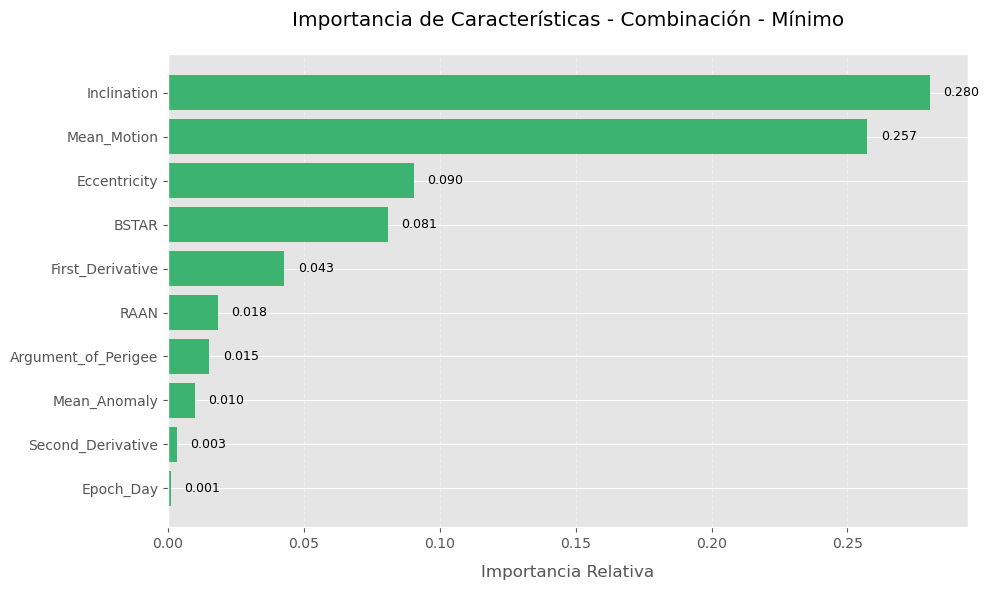

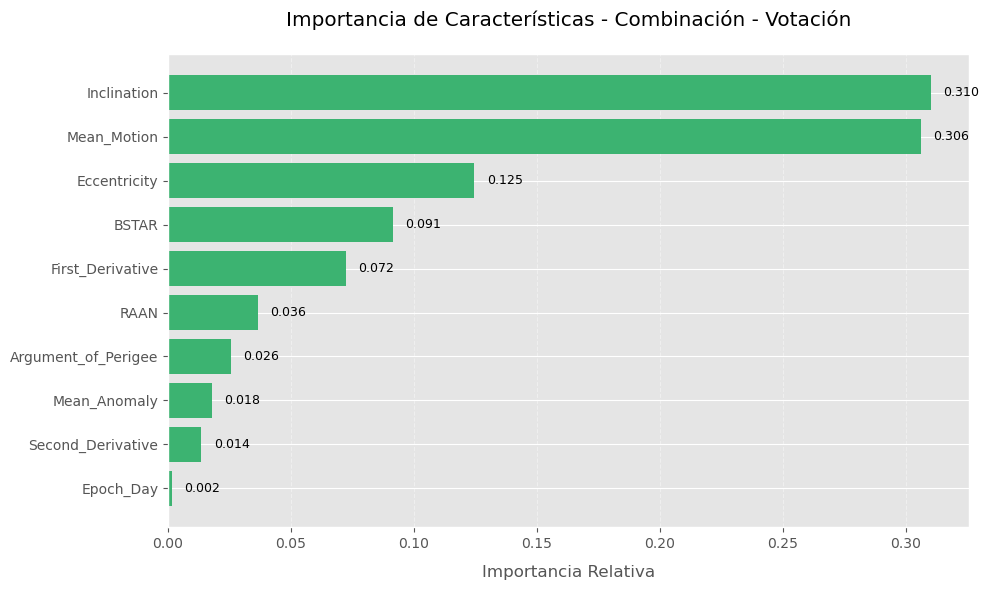

In [15]:
def analyze_feature_importance_extended(trained_models, features, X_val_scaled):
    # 1. Análisis para modelos individuales
    print("\n=== IMPORTANCIA PARA MODELOS INDIVIDUALES ===")
    
    for name, model in trained_models.items():
        if name not in ['SVM', 'Random Forest', 'XGBoost']:
            continue
            
        try:
            if hasattr(model, 'feature_importances_'):  # Para Random Forest, XGBoost
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):  # Para SVM
                if len(model.coef_.shape) > 1:  # SVM multiclase
                    # Usamos la norma L2 de los coeficientes para cada característica
                    importances = np.linalg.norm(model.coef_, axis=0)
                else:  # SVM binario
                    importances = np.abs(model.coef_[0])
            else:
                print(f"{name} no soporta análisis de importancia estándar")
                continue
                
            # Normalizar y visualizar
            importances = importances / importances.sum()
            plot_feature_importance(name, importances, features)
            
        except Exception as e:
            print(f"Error analizando {name}: {str(e)}")
    
    # 2. Análisis para combinaciones durante su creación
    print("\n=== IMPORTANCIA PARA COMBINACIONES ===")
    
    # Obtener modelos base
    base_models = [trained_models[name] for name in ['SVM', 'Random Forest', 'XGBoost'] if name in trained_models]
    
    if not base_models:
        print("No hay modelos base para combinar")
        return
    
    # Calcular importancia base promedio (para usar en combinaciones)
    base_importances = []
    for model in base_models:
        if hasattr(model, 'feature_importances_'):
            imp = model.feature_importances_
        elif hasattr(model, 'coef_'):
            if len(model.coef_.shape) > 1:
                imp = np.linalg.norm(model.coef_, axis=0)
            else:
                imp = np.abs(model.coef_[0])
        else:
            continue
        base_importances.append(imp / imp.sum())
    
    if not base_importances:
        print("No se pudo calcular importancia para combinaciones")
        return
    
    avg_base_importance = np.mean(base_importances, axis=0)
    
    # Visualizar importancia para cada tipo de combinación
    plot_feature_importance("Combinación - Promedio", avg_base_importance, features)
    plot_feature_importance("Combinación - Máximo", np.max(base_importances, axis=0), features)
    plot_feature_importance("Combinación - Mínimo", np.min(base_importances, axis=0), features)
    
    # Para votación mayoritaria podríamos ponderar por precisión
    plot_feature_importance("Combinación - Votación", avg_base_importance, features)

def plot_feature_importance(model_name, importances, features):
    """Visualización mejorada de importancia de características"""
    df = pd.DataFrame({'Feature': features, 'Importance': importances})
    df = df.sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df['Feature'], df['Importance'], 
                   color='dodgerblue' if 'Combinación' not in model_name else 'mediumseagreen')
    
    plt.title(f'Importancia de Características - {model_name}', pad=20)
    plt.xlabel('Importancia Relativa', labelpad=10)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Añadir valores
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Uso:
analyze_feature_importance_extended(trained_models, features, X_val_scaled)

## 9. Predicción de Ejemplo

Finalmente, se selecciona una **muestra aleatoria del conjunto de validación** para realizar una predicción. Se muestran las **predicciones y las probabilidades (si están disponibles)** de todos los modelos entrenados (individuales y combinados) para este ejemplo, comparándolas con la etiqueta real.

In [16]:
# Preparación del diccionario de todos los modelos
all_models_for_prediction = {}
all_models_for_prediction.update(trained_models)


if 'model_list_to_combine' in locals() and model_list_to_combine and 'probs_from_base_models' in locals() and 'preds_from_base_models' in locals() and 'le' in locals():
    if can_do_prob_combination and probs_from_base_models:
        all_models_for_prediction["Combinación - Promedio Probs"] = CombinedModel(np.mean(probs_from_base_models, axis=0), le.classes_)
        max_p_val = np.max(probs_from_base_models, axis=0)
        all_models_for_prediction["Combinación - Máximo Probs (Normalizado)"] = CombinedModel(np.divide(max_p_val, np.sum(max_p_val, axis=1, keepdims=True), out=np.zeros_like(max_p_val), where=np.sum(max_p_val, axis=1, keepdims=True)!=0), le.classes_)
        min_p_val = np.min(probs_from_base_models, axis=0)
        all_models_for_prediction["Combinación - Mínimo Probs (Normalizado)"] = CombinedModel(np.divide(min_p_val, np.sum(min_p_val, axis=1, keepdims=True), out=np.zeros_like(min_p_val), where=np.sum(min_p_val, axis=1, keepdims=True)!=0), le.classes_)
        weights_val = [0.2, 0.3, 0.5]
        if len(weights_val) == len(probs_from_base_models):
            all_models_for_prediction["Combinación - Promedio Ponderado Probs"] = CombinedModel(np.tensordot(weights_val, probs_from_base_models, axes=(0,0)), le.classes_)
    if preds_from_base_models.size > 0:
        all_models_for_prediction["Combinación - Votación Mayoritaria"] = VotingModel(np.apply_along_axis(lambda x: np.bincount(x, minlength=len(le.classes_)).argmax(), axis=0, arr=preds_from_base_models), le.classes_)
else:
    print("Advertencia: Variables para recrear modelos combinados no encontradas. Solo se usarán modelos individuales.")


# Seleccionamos y preparamos un ejemplo aleatorio de df_val_model
if not df_val_model.empty:
    sample_idx = np.random.randint(0, len(df_val_model))
    sample_features_unscaled = df_val_model[features].iloc[sample_idx:sample_idx+1]
    true_name = df_val_model['Name'].iloc[sample_idx]
    true_label = df_val_model[target].iloc[sample_idx]
    true_encoded = y_val_encoded[sample_idx]
    sample_features_scaled = scaler.transform(sample_features_unscaled)

    print(f"\n--- Ejemplo Aleatorio de Validación (índice en df_val_model: {sample_idx}) ---")
    print(f"Nombre: {true_name}, Grupo Real: {true_label} (Codificado: {true_encoded})")

    # Realizamos predicciones con todos los modelos
    print("\n--- Predicciones de los Modelos ---")
    for model_name, model_obj in all_models_for_prediction.items():
        pred_enc, probas_all_classes = None, None
        
        if isinstance(model_obj, (CombinedModel, VotingModel)): 
            pred_enc = model_obj.predict(None)[sample_idx:sample_idx+1]
            if hasattr(model_obj, "predict_proba"):
                probas_all_classes = model_obj.predict_proba(None)[sample_idx]
        else: 
            pred_enc = model_obj.predict(sample_features_scaled)
            if hasattr(model_obj, "predict_proba"):
                probas_all_classes = model_obj.predict_proba(sample_features_scaled)[0]
        
        pred_lab = le.inverse_transform(pred_enc)[0]
        print(f"\nModelo: {model_name}\n  Predicción: {pred_lab} (Codificado: {pred_enc[0]})")
        
        if probas_all_classes is not None:
            top_indices = np.argsort(probas_all_classes)[::-1][:min(3, len(le.classes_))]
            print("  Top 3 probabilidades:")
            for class_idx in top_indices:
                print(f"    {le.classes_[class_idx]}: {probas_all_classes[class_idx]:.2%}")
        else:
            print("  (Probabilidades no disponibles)")
else:
    print("df_val_model está vacío.")


--- Ejemplo Aleatorio de Validación (índice en df_val_model: 21387) ---
Nombre: NOAA 5, Grupo Real: noaa (Codificado: 21)

--- Predicciones de los Modelos ---

Modelo: SVM
  Predicción: fengyun 1c debris (Codificado: 6)
  Top 3 probabilidades:
    noaa: 76.36%
    analyst: 3.61%
    fengyun 1c debris: 3.22%

Modelo: Random Forest
  Predicción: noaa (Codificado: 21)
  Top 3 probabilidades:
    noaa: 50.05%
    analyst: 20.51%
    satnogs: 15.40%

Modelo: XGBoost
  Predicción: noaa (Codificado: 21)
  Top 3 probabilidades:
    noaa: 72.96%
    satnogs: 23.04%
    analyst: 2.64%

Modelo: Combinación - Promedio Probs
  Predicción: noaa (Codificado: 21)
  Top 3 probabilidades:
    noaa: 66.46%
    satnogs: 13.41%
    analyst: 8.92%

Modelo: Combinación - Máximo Probs (Normalizado)
  Predicción: noaa (Codificado: 21)
  Top 3 probabilidades:
    noaa: 52.36%
    satnogs: 15.79%
    analyst: 14.06%

Modelo: Combinación - Mínimo Probs (Normalizado)
  Predicción: noaa (Codificado: 21)
  Top 3 pr

## 10. Conclusiones Y Lineas de Futuro

### **- Modelo con mejor rendimiento y análisis de su superioridad**

- El modelo individual **XGBoost** demostró ser el más performante, alcanzando una precisión del **99.35%**. Esta superioridad podría atribuirse a su arquitectura basada en árboles de decisión potenciados (**gradient boosting**), que le permite capturar eficazmente relaciones no lineales complejas y realizar una selección de características intrínseca, aspectos cruciales dada la naturaleza física de los datos orbitales. Es posible que la estructura de los datos de **TLEs** se ajuste particularmente bien a la forma en que **XGBoost** aprende y divide el espacio de características.
- Aunque la **combinación por promedio ponderado (99.25%)** se acercó notablemente, la pregunta de por qué un modelo individual supera ligeramente a las combinaciones es pertinente. Las combinaciones de modelos suelen buscar **robustez y una mejor generalización** al reducir la varianza y el riesgo de sobreajuste inherente a un único modelo. Son teóricamente más fuertes ante datos no vistos o con ligeras variaciones.
- Para determinar si las combinaciones ofrecen una ventaja tangible en términos de robustez en este escenario específico (a pesar de la ligera diferencia en precisión), sería necesario un estudio más profundo:
  - **Línea Futura Sugerida**: Evaluar los modelos en múltiples subconjuntos de datos de prueba (utilizando, por ejemplo, validación cruzada repetida o *bootstrapping* sobre el conjunto de prueba si es lo suficientemente grande) o bajo condiciones de datos ligeramente perturbados (simulando ruido o pequeñas variaciones en los **TLEs**). Si las combinaciones mantienen un rendimiento más estable o se degradan menos que **XGBoost** individual en estas condiciones, se confirmaría su mayor robustez.

### **- Características más importantes**

El análisis de importancia de características (mencionado en el apartado 8 del trabajo) identificó la **Inclinación**, el **Movimiento Medio (Mean Motion)** y la **Excentricidad** como los parámetros orbitales más influyentes para la clasificación de los subgrupos de satélites. Estos datos fueron cruciales tanto para el rendimiento de los modelos individuales como para las estrategias de combinación.

### **- Análisis de satélites Unknown**

- El análisis específico de los satélites etiquetados como **"Unknown"** no se abordó en la fase actual del proyecto, quedando como una línea de trabajo futura.
- Se contempla que la aplicación de los modelos desarrollados a este grupo podría permitir identificar posibles agrupaciones basadas en sus características orbitales (como las mencionadas **Inclinación**, **Movimiento Medio** y **Excentricidad**) o inferir su naturaleza, aunque actualmente siguen siendo ambiguos.

### **- Aplicaciones prácticas**

- Clasificación automática de nuevos **TLEs** para una rápida asignación a subgrupos funcionales o de naturaleza similar.
- Apoyo a la catalogación y vigilancia espacial, permitiendo una mejor comprensión de la distribución y características de diferentes poblaciones de objetos.
- Potencial para identificar objetos con características orbitales atípicas si son clasificados de manera inesperada por los modelos.

### **- Limitaciones**

- El rendimiento está intrínsecamente ligado a la calidad, completitud y actualidad de los datos **TLE** de **Space-Track**.
- El modelo actual está entrenado para clasificar subgrupos y no para la identificación individual dentro del catálogo completo (considerando las ~60,000 clases originales).
- No se han incorporado análisis dinámicos a largo plazo de la evolución orbital, centrándose en la información de **TLEs** puntuales.
- A pesar del tratamiento del desbalanceo (ej. submuestreo de **Starlink**), la representación de algunas clases minoritarias podría aún limitar la generalización en esos grupos específicos.


In [17]:
# Visualicemos las precisiones de los diferentes modelos
data = {
    "Modelo": ["SVM (SVC)", "Random Forest", "XGBoost (XGBClassifier)"],
    "Precisión":  [0.8870,      0.9576,    0.9935 ]
}
data2 = {
    "Combinación de Modelos": [ "Combinación por promedio", "Combinación por máximo" , "Combinación por mínimos", "Combinación por promedio ponderado", "Combinación por votación mayoritaria"],
    "Precisión": [ 0.9883 ,  0.9891 ,  0.9800 , 0.9925, 0.9774]
}
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

# Mostrar los DataFrames en un entorno como Jupyter Notebook:
print("Tabla-resumen de Accuracy - Modelos Individuales:")
print(df)
print("\nTabla-resumen de Acc. - Combinación de modelos:")
print(df2)

Tabla-resumen de Accuracy - Modelos Individuales:
                    Modelo  Precisión
0                SVM (SVC)     0.8870
1            Random Forest     0.9576
2  XGBoost (XGBClassifier)     0.9935

Tabla-resumen de Acc. - Combinación de modelos:
                 Combinación de Modelos  Precisión
0              Combinación por promedio     0.9883
1                Combinación por máximo     0.9891
2               Combinación por mínimos     0.9800
3    Combinación por promedio ponderado     0.9925
4  Combinación por votación mayoritaria     0.9774
